In [1]:
from IPython.display import Image
from IPython.display import SVG

# <a id="1.Summary"> 1.Summary</a>

I have attached a spreadsheet containing five years of production and weather data for our Middlesex, NJ and Bethlehem, PA facilities. When looking at the production data if the “BatchNumber” listed starts with PASD it was done in Bethlehem and if it starts with NJSD it was done in Middlesex. I included some info that we have on flowability and hygroscopicity but it’s not empirical data; mostly a judgement call made for “reasons”. Weather data was downloaded from openweathermap.org, temperatures are in °F. Let me know if you need any clarification on the data provided.


More specifically, given the dependence of their drying products and services on weather
conditions, the company is interested in using weather data to forecast the processing times for
different batches of SKUs. 

The team is expected to:

• Develop a database with manufacturing data that will be used to develop statistical
models

• Develop, manage and maintain statistical models, including but not limited to:

o Forecasting of processing times based on weather data

o Forecasting downtime and preventive maintenance issues

<br>

<br>

<br>

# <a id="2.Table of Contents">2.Tabole of Contents</a>
<a href="#1.Summary">Click this Link back to Top</a>

<ol>
    <li><a href="#1.Summary">Summary</a></li>
    <li><a href="#2.Tabole of Contents">Tabole of Contents</a></li>
    <li><a href="#3.Preprocess">Preprocess</a>
    <ul>
        <li><a href="#3.1 Hyperparameter">3.1 Hyperparameter</a></li>
        <li><a href="#3.2 Import Data">3.2 Import Data</a></li>
        <li><a href="#3.3 EDA">3.3 EDA</a></li> 
        <li><a href="#3.4 Preprocess">3.4 Preprocess</a></li> 
        <li><a href="#3.5 Merge Data">3.5 Merge Data</a></li>    
    </ul>
    </li>
    <li><a href="#4.Others">Others</a>
    <ul>
        <li><del><a href="#TFIDF">4.1 TFIDF</a></del></li>
        <li><del><a href="#Embedding">4.2 Embedding</a></del></li> 
    </ul>
    </li>
    <li><del><a href="#5.Classify">Classify</a></del></li>
    <li><del><a href="#6.Models">Models</del></a>
    <ul>
        <li><a href="#6.1 Model1">6.1 Model1</a></li>
        <li><a href="#6.2 Model2">6.2 Model2</a></li>
    </ul>
    </li>
    <li><a href="#7.Main Function">Main Function</a></li>
    <li><a href="#9.Test Code">Test Code</a></li>
</ol>

In [2]:
SVG('04_images/42_flowchart.svg')

<br>

<br>

<br>

# <a id="3.Preprocess">3.Preprocess</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

1. transform data column into identical format
2. split data into two station part: NJ and PA
3. For each hour data, we have multi rows if there are two differnet weather condition(Snow / Frog)

## <a id="3.1 Hyperparameter">3.1 Hyperparameter</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [3]:
class HyperParamters(object):
    """
    This class will be used to transmit hyperparameters between class.parameters
    Most of class can inherit this class and its hyperparameters

    ########################__Rules__##################################
    class file name = class + _ + number of sequence + function name
    class name = ClassType (Camel-Case)
    function name = function_name
    variable name = attribute_type_describe (Hungarian notation) # sometime I don't use attribute
    constant = UPPERCASE
    ###########################################################################


    ########################__Notation__############################################
    1. We might need split data into two place NJ and PA, but we also can try to merge two location into one,
    because they are not far away
    2. clean data, transform date format, join by date, Coeffience anaylsis
    3. Check kaggle format
    4. Check journals
    5. Traditional way is to find relationship between total running time with other weather features
    6. But we need to consider equipment service lift or depreciation will affect running time
    7. Sometimes, we don't use running time itself, we can use the statiscal version of this data
    For example, runing time - avg , variance of each running time data point
    8.
    #############################################################################

    1.change import data path


    There is a little space in class_34_proprocess, we elimiate some error record by mannully,
    This is not general proceedure, we can comments that part of code any time
    """

    def __init__(self):
        """:arg


        """
        self.TEST = 1

        # you can change this root path in this class and import_data() function will search from this root dictionary
        self.ROOTPATH = 'D:\\OneDrive\\03_Academic\\23_Github\\20_Stevens\\66-MGT-809-A\\03_data'


        # assign the column will be dropped in production table
        # we believe these columns are objective result or not useful features
        # ['Bulk Density'] is too objective
        # ['Moisture'] is decided by custome requirement, that might affect drying time
        # ['Hygroscopicity'] imbalance data distribution
        self.PRODUCT_DROP = ['Bulk Density', 'Moisture','Flow', 'Hygroscopicity']


        # these are the un-related columns in weather data
        # ['timezone'] will change from -18000 to -14400 because winter time to summer time, vsia. We can delete it
        self.WEATHER_DROP = ['dt_iso', 'timezone', 'city_name', 'lat', 'lon']
        # These columns are non-numerical data, if we need use these columns, we can add them back,
        # for now, I will delete them in this hyperparameters
        # self.WEATHER_DROP = ['dt_iso', 'timezone', 'city_name', 'lat', 'lon',
        #                      'weather_id', 'weather_main', 'weather_description', 'weather_icon']


        # sometimes operater repack powder back to dryer again because it's not meet particular size requirement
        # we use z-score as our defination, If we set threshold as 3, the yeild great than 130% will be eliminate
        # we also have a np.abs() for smaller outliers, which also affected by this threshold
        # when we set our threshold to 3, we eliminate the percentage great then 130%,
        # set to 1.5, then delete precentage greater than 111% (106 rows was dropped)
        # 3 - 130% /  1.5 - 111%   / 1 - 104.6%
        self.YEILD_THRESHOLD = 1.5
        # ['Rate'] is our target output, we more concens this colunm's statistcal results.
        # Typically rate can be as high as possible, but sometimes, the extramly high rate is operation error
        # We will try to identify ourlier by z-socre and Interquartile Range method
        # If we shrink our threshold to a small number, we will delete more outliers. But they might not be delete so early
        # For example, in index ['821', '2983','2999'] after manually double chek, they are operation error.
        # We can't do this to every ['Rate'] outliers. So we can do this drop process only for statiscal visulzation
        self.IQR_THRESHOLD = 2

        # using two sigma and three sigma to delete those extramlly higher ['Rate']
        # two sigma will CDF = 95%, for each on side, it will be 2.5%
        self.TWO_SIGMA = 2.5
        # if we don't want delete less rows, we can use three sigma, it will only delete approcimate 30 rows.
        # self.THREE_SIGMA = 0.3


        self.NN_OUTPUT = 5
        # self.NN_OUTPUT = 10

<br>

<br>

<br>

## <a id="3.2 Import Data">3.2 Import Data</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [4]:
# from class_31_hyperparameters import HyperParamters

# read xlxs file
import pandas as pd
# record running data
from time import time
# join directory path
import os




class ImportData(HyperParamters):
    """
    Contain two method: import data and convert time


    """
    def __init__(self):
        # inhereit from HyperParameter
        HyperParamters.__init__(self)


    def import_data(self):
        """:arg

        Returns:
        ----------
        df_product:DataFrame
            real production data including running time
        df_nj_weather:DataFrame
            Middlesex, NJ factory weather data from openweather.org
        df_pa_weather:DataFrame


        """
        print("*" * 50, "Start import_data()", "*" * 50)
        start_time = time()

        # create excel full paht directory
        excel_product = os.path.join(self.ROOTPATH, '019_20160101_20201231_ProductionData.xlsx')
        # first sheet is real production data
        df_product = pd.read_excel(excel_product, sheet_name = '20160101_20201231_ProductionDat')
        # second sheet is NJ weather data
        df_nj_weather = pd.read_excel(excel_product, sheet_name = 'MiddlesexWeather')
        # third sheet is PA weather data
        df_pa_weather = pd.read_excel(excel_product, sheet_name = 'BethlehemWeather')
        # this new data missing rate, so we have to import old data and merge ['Rate'] to our new data
        old_product = os.path.join(self.ROOTPATH, '017_20160101_20201231_ProductionData.xlsx')
        df_old = pd.read_excel(old_product, sheet_name = '20160101_20201231_ProductionDat')
        # in this version data provided by customer, it didn't have ['Rate'] column
        df_product['Rate'] = df_old['Rate']
        # We need a sign for identifacation for each records.
        # We can use current index to generate a new column called ['Index_ID'] for our key schema/value
        # df_product['Index_ID'] = df_product.index

        # save product with first column as index ['Unname 0']
        df_product.to_csv('03_data/20_production.csv',index=True)
        df_nj_weather.to_csv('03_data/21_nj_weather.csv', index=False)
        df_pa_weather.to_csv('03_data/22_pa_weather.csv', index=False)

        cost_time = round((time() - start_time), 4)
        print("*" * 40, "End import_data() with {} second".format(cost_time), "*" * 40, end='\n\n')

        return df_product, df_nj_weather, df_pa_weather

    def read_csv(self):
        """":arg
        Because reading excel is too slow, so we use this function to read csv that processed and saved by
        import_data() function.
        """
        df_product = pd.read_csv('03_data/20_production.csv')
        # change the first column as our identical featuers
        df_product.rename(columns={'Unnamed: 0': 'Index_ID'}, inplace=True)
        df_nj_weather = pd.read_csv('03_data/21_nj_weather.csv')
        df_pa_weather = pd.read_csv('03_data/22_pa_weather.csv')


        return df_product, df_nj_weather, df_pa_weather



<br>

<br>

<br>

## <a id="3.3 EDA">3.3 EDA</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [5]:
# from class_31_hyperparameters import HyperParamters

# used for visulazation
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import squarify

class EDA(HyperParamters):
    """:arg
    """
    def __init__(self):
        """:arg
        """
        HyperParamters.__init__(self)

    def missing_plot(self, df: pd.DataFrame):
        """:arg

        Used for missing data plot for count plot and percenatage plot
        """
        # not all columns contain missing value, we only plot the colunms have missing value
        # checking is there any missing value in this df and find threir column names and assign to col_missing_value
        col_missing_value = list(df.columns[df.isnull().any()])
        # count the missing value for each column
        df[col_missing_value].isnull().sum()
        # to hold the columns names
        list_labels=[]
        # to hold the count of missing values for each variable
        list_value_count=[]
        # to hold the percentage of missing values for each variable
        list_percent_count=[]
        #
        for col in col_missing_value:
            # add the column names into this list
            list_labels.append(col)
            # caculate each column missing value count and append to list
            list_value_count.append(df[col].isnull().sum())
            # df.shape[0] will give totoal row count
            list_percent_count.append(df[col].isnull().sum()/df.shape[0])


        # create two subplot with 1 row two columns
        fig, (ax1, ax2) = plt.subplots(1,2)
        # we use ax.barh() create horizontal bar chart, bar width is the count number of missing value
        ax1.barh(y = np.arange(len(list_labels)),width = np.array(list_value_count), height=0.5, color='blue')
        # set lenght of y labels
        ax1.set_yticks(np.arange(len(list_labels)))
        # set y labels
        ax1.set_yticklabels(list_labels, rotation='horizontal')
        ax1.set_xlabel('Count of missing values')
        ax1.set_title("Columns with missing value count")

        ax2.barh(y=np.arange(len(list_labels)), width = np.array(list_percent_count), height=0.5, color='red')
        ax2.set_yticks(np.arange(len(list_labels)))
        ax2.set_yticklabels(list_labels, rotation='horizontal')
        ax2.set_xlabel("Percentage of missing values")
        ax2.set_title("Columns with missing values")

        plt.show()
        # print(col_missing_value, type(col_missing_value))

        return col_missing_value


    def bcr_dryer(self, df_product, df_nj_weather, df_pa_weather):
        """
        This fucntion used for bar_chart_race library data reconstruction.
        This function will present the relationship between ['Dryer'] and time

        https://www.wikihow.com/Install-FFmpeg-on-Windows

        Args:
        -----
        df_product:pd.DataFrame
            We into

        Returns:
        ------
        df
        """
        # due to format unification, we need transform ['dt_date'] to its string type
        df_nj_weather.loc[:, ('str_date')] = df_nj_weather['dt_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
        df_pa_weather.loc[:, ('str_date')] = df_pa_weather['dt_date'].apply(lambda x: x.strftime('%Y-%m-%d'))

        # direct merge on ['dt_est'] without split each row to several hours rows
        # because we only care about its accumualte results, so just extract combination of location and time
        df_nj = pd.merge(df_product, df_nj_weather, on=['dt_est'], how='left')
        df_pa = pd.merge(df_product, df_pa_weather, on=['dt_est'], how='left')


        # ***********This part logic have some problem, we need delete duplicate from weather first ************
        # in same day, it might have two weather condition, so when you merge data, it will appear duplicate records
        # we know it will be duplicate when we merge with product data because some duplicate weather data
        print('Before drop duplicate, {}, {}'.format(df_nj.shape, df_pa.shape))
        # ['StartDate'] is unipue, other columns more or less contain same records
        # we keep the first records and directly do this action on current DataFrame
        df_nj.drop_duplicates(subset=['StartDate'], keep='first', inplace=True)
        df_pa.drop_duplicates(subset=['StartDate'], keep='first', inplace=True)
        print('After drop duplicate, {}, {}'.format(df_nj.shape, df_pa.shape))


        # extract each dryer from df_product
        df_01 = df_nj.loc[df_nj['Dryer'] == 'Dryer 01']
        df_02 = df_nj.loc[df_nj['Dryer'] == 'Dryer 02']
        df_03 = df_nj.loc[df_nj['Dryer'] == 'Dryer 03']
        df_04 = df_nj.loc[df_nj['Dryer'] == 'Dryer 04']
        df_06 = df_pa.loc[df_pa['Dryer'] == 'Dryer 06']
        df_07 = df_pa.loc[df_pa['Dryer'] == 'Dryer 07']
        df_08 = df_pa.loc[df_pa['Dryer'] == 'Dryer 08']
        df_10 = df_pa.loc[df_pa['Dryer'] == 'Dryer 10']

        # in each day, there might be several orders in one dryer, so we need to sum one day data into one row
        series_01_cum = df_01.groupby(by=['str_date'])['ActualDryQty'].sum().cumsum()
        series_02_cum = df_02.groupby(by=['str_date'])['ActualDryQty'].sum().cumsum()
        series_03_cum = df_03.groupby(by=['str_date'])['ActualDryQty'].sum().cumsum()
        series_04_cum = df_04.groupby(by=['str_date'])['ActualDryQty'].sum().cumsum()
        series_06_cum = df_06.groupby(by=['str_date'])['ActualDryQty'].sum().cumsum()
        series_07_cum = df_07.groupby(by=['str_date'])['ActualDryQty'].sum().cumsum()
        series_08_cum = df_08.groupby(by=['str_date'])['ActualDryQty'].sum().cumsum()
        series_10_cum = df_10.groupby(by=['str_date'])['ActualDryQty'].sum().cumsum()

        # create a new time base DataFrame for next step merge with time range and type=datetime.time
        df_base = pd.DataFrame(data=pd.date_range(start='1/2/2016', end='12/31/2020'), columns=['dt'])
        # because next step we need to merge and using bar_race_chart librayr,
        # so we tranform date into same format and type and restore into new column ['str_date']
        df_base.loc[:, ('str_date')] = df_base['dt'].apply(lambda x: x.strftime('%Y-%m-%d'))
        # in brc() library, it use time (string type) as index
        df_base = df_base.set_index('str_date')
        # concatnate data by columns, so rows is time index from df_base with everyday for these 5 years
        # for each dryers, it might have someday don't work
        df_bcr = pd.concat([df_base, series_01_cum], axis=1)
        df_bcr = pd.concat([df_bcr, series_02_cum], axis=1)
        df_bcr = pd.concat([df_bcr, series_03_cum], axis=1)
        df_bcr = pd.concat([df_bcr, series_04_cum], axis=1)
        df_bcr = pd.concat([df_bcr, series_06_cum], axis=1)
        df_bcr = pd.concat([df_bcr, series_07_cum], axis=1)
        df_bcr = pd.concat([df_bcr, series_08_cum], axis=1)
        df_bcr = pd.concat([df_bcr, series_10_cum], axis=1)
        # only reserve dryers columns
        df_bcr.drop(labels=['dt'], axis=1, inplace=True)
        df_bcr.columns = ['Dryer 01', 'Dryer 02', 'Dryer 03', 'Dryer 04', 'Dryer 06', 'Dryer 07', 'Dryer 08',
                          'Dryer 10']
        # this is used to fullfill with contiuous data in days that dryers dont' have task
        df_bcr = df_bcr.interpolate()
        # full fill some early day, like 01/01/2016, that interpolate() can't full fill
        df_bcr.fillna(0, inplace=True)
        # it's more easy to read file and start processing to movies
        df_bcr.to_csv('03_data/27_bcr.csv', index=True)

        # because each row is already start from on day, so we can directly use ['ActualDrayQty'] to cumulate sum
        #     df_01.loc[:,('cumsum')] = df_01['ActualDryQty'].cumsum()
        #     df_02.loc[:,('cumsum')] = df_02['ActualDryQty'].cumsum()

        #     df_20 = pd.DataFrame(data=[df_14['dt_date'], df_14['cumsum']])
        #     df_21 = df_20.T
        #     df_21['str_date'] = df_21['dt_date'].apply(lambda x:x.strftime('%Y-%m-%d'))
        #     df_22 = df_21.set_index('str_date')

        #     # merge
        #     df_bcr = pd.merge(df_base, df_01, on=['str_date'], how='left')
        #     df_bcr = pd.merge(df_bc)

        # create a new DataFrame for  bar_race_chart
        #     df_bcr = pd.DataFrame()

        return df_base, df_bcr

    def squrify_treemap(self, df, col_name='ProdLine', bool_groupby = False):
        """
        Args:
        ------
        df:pd.DataFrame
            data source
        col_name:string
            the column you want to plot
        bool_groupby:boolean
            if bool_groupby = True, we need to groupby this dataframe, If False, we can directly use dataframe

        :return:
        """
        if bool_groupby:
            # create a new dataframe with groupby list and its corresponding count size
            df_map = df.groupby(by=[col_name]).size().reset_index(name='counts')
        else:
            df_map = df.copy()
        # create labels for squrify demonstration
        # defalut apply() direction is vertical, we push a column series to apply() function and default axis=0
        # In default, x will be two column features and x[0] will be the first element for this two column features
        # which are chemicl and 229(size/count of chemical)
        # So when you change axis=1, the output x become row direction output, x[0] will become all name of first column
        # Lable will be category name + its groupby size
        series_labels = df_map.apply(lambda x : str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
        # squrify library need into the box size with list format
        list_sizes = df_map.iloc[:,1].values.tolist()
        # create colors by length of existing labels, for example, we have 8 category, Spectral will provide 8 colors
        list_colors = [plt.cm.Spectral( i/float(len(series_labels))) for i in range(len(series_labels))]
        # set the plot size, weight=20 is just fit jupter notebook weight
        plt.figure(figsize = (20,8), dpi=80)
        squarify.plot(sizes = list_sizes, label = series_labels, color = list_colors, alpha=1.0)
        #title
        plt.title("Treemap of")
        plt.axis('off')
        plt.show()

        return None





<br>

<br>

<br>

## <a id="3.4 Preprocess">3.4 Preprocess</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [6]:
# from class_31_hyperparameters import HyperParamters
# from class_33_eda import EDA

# using for timestap convert
import pandas as pd
import numpy as np
from scipy import stats
# recording running time in each function
from time import time



class PreProcess(HyperParamters):
    """:arg
    Actually, not only production data need to be clean.

    tz_convert(): used to convert string to timestamp format
    """

    def __init__(self):
        """:arg
        Inheriret from HyperParamters
        """
        HyperParamters.__init__(self)


    def tz_convert(self, series):
        """:arg
        Args:
        ------
        serise:DataFrame.series
            each element from DataFrame columns

        Returns:
        -----------
        series_est:timestamp

        """
        series_est = pd.Timestamp(series, unit='s', tz='America/New_York')

        return series_est

    def tz_y_m_d(self, ts):
        """
        ******************This function is not use anymore*******************
        ******************This function is not use anymore*******************
        ******************This function is not use anymore*******************
        We use this function to convert Timestamp to year/quarter/month/day

        Args:
        ------
        ts:pd.Timestamp
            ['dt_est']

        Returns:
        -------
        year:int
        quarter:int
        month:int
        day:int
        """
        year = ts.year
        quarter = ts.quarter
        month = ts.month
        day = ts.day
        hour = ts.hour
        dt_date = ts.date()
        return year, quarter, month, day, hour, dt_date

    def convert_yymmdd(self, df:pd.DataFrame, col_name):
        """
        extract year/quarter/month/day from timestamp and add to new column

        col_name:string
            It should be a TimeStamp column like ['dt_est']
        """
        df.loc[:, 'year'] = df[col_name].apply(lambda x: x.year)
        df.loc[:, 'quarter'] = df[col_name].apply(lambda x: x.quarter)
        df.loc[:, 'month'] = df[col_name].apply(lambda x: x.month)
        df.loc[:, 'day'] = df[col_name].apply(lambda x: x.day)
        df.loc[:, 'hour'] = df[col_name].apply(lambda x: x.hour)
        df.loc[:, 'dt_date'] = df[col_name].apply(lambda x: x.date())

        return df

    def round_to_hour(self,timestamp):
        """
        We notice df_product['StartDat'] is string type not DataFrame.timestamp.
        And weather data are seperated by hours, so we need transform string time data round to nearest hour

        Args:
        --------
        timestamp
        """
        # due to excel convert to csv, all format are lost and original timestamp has transformed to 'string'
        # so we add a duplicate process to convert 'string' to 'timestamp'
        timestamp = pd.Timestamp(timestamp)
        # because of summer time and winter time rules, some UTC date can't conver to EST
        try:
            date_hour = timestamp.round(freq='H').tz_localize(tz='America/New_York', nonexistent='shift_forward')
        except:
            print('This data cant convert correctly {}'.format(timestamp.round(freq='H')))
            date_hour = timestamp.round(freq='H').tz_localize(tz='America/New_York',
                                                              ambiguous='NaT',
                                                              nonexistent='shift_forward')
            print('This date replaced by {}'.format('NaT'))

        return date_hour


    def z_outlier(self, df, str_col, z_threshold  = 3, abs=False):
        """
        We use z-score to delete outliers in our data. for example ['YieldPrecentage'] and ['Rate']
        When ads=True, it will delete smallest and biggest outliers.
        When ads=False, it will only delete outliers ['YieldPercentage']> 130%, which means remain [0,130]

        Args:
        ------
        df:DataFrame
            Any dataframe
        str_col:str
            the name of column you want to detect outliers and drop

        Returns:
        --------
        df_clean:DataFrame
            df has been dropped
        df_outlier:DataFrame
            The rows that has been detected as outliers
        """
        if abs:
            # if abs=True, we will absolute z-score and find the both side outliers
            z_score = np.abs(stats.zscore(df[str_col], nan_policy='omit'))
            print("We will drop too large and too small outliers")
            index_outlier = df[z_score > z_threshold].index
        else:
            # if abs=False (default setting), we only delete the too large outlers
            z_score = stats.zscore(df[str_col], nan_policy='omit')
            print("we will only drop too large outliers")
            index_outlier = df[(z_score > z_threshold) | (z_score < -z_threshold)].index
        # set a z-score threshold, any greater than this value will be eliminate
        # z_threshold = 3
        # filter that ooutlier rows in dataframe
        # index_outlier = np.where(z_score > z_threshold, z_score)
        # get the index of these outliers
        # index_outlier = df[z_score > z_threshold].index
        # restore these outliers in df_outlier for further review
        df_outlier = df.loc[index_outlier,:]
        print('We have {} data points are outliers, which between {} and {}'.format(len(index_outlier),
                                                                                    df_outlier[str_col].min(),
                                                                                    df_outlier[str_col].max()))
        # drop these rows by index
        df_clean = df.drop(axis=0, index=index_outlier)
        print("After drop outlier, the {} column remain range between {} and {}".format(str_col,
                                                                                        df_clean[str_col].min(),
                                                                                        df_clean[str_col].max()))
        return df_clean, df_outlier



    def iqr_outlier(self, df, str_col, iqr_threshold=3):
        """:arg
        Except z-socre, we also have also have 'Interquartile Range Method' to deal with non-Gaussian distribution

        Args:
        -----
        df:pd.DataFrame

        """
        print('Start using IQR to eliminate outliers.')
        # caculate interquartile range
        q75, q25 = np.percentile(df[str_col], 75), np.percentile(df[str_col], 25)
        # IQR can be used to identify outliers by defining limits on the sample values that are a factore k
        iqr = q75 - q25
        # of the IQR below the 25th percentile or above the 75th percentile. The commmon value of k is 1.5
        # A factor k of 3 or more can be used to identify values that are extrmel outliers
        cut_off = iqr * iqr_threshold
        # get the lower bound and upper bound
        lower_bound, upper_bound = q25-cut_off, q75+cut_off
        # so we can use these bounds to identify outliers and remaining data
        df_outlier = df.loc[(df[str_col]>upper_bound) | (df[str_col]<lower_bound)]
        print('In {} column using {} as threshold'.format(str_col,iqr_threshold))
        print('We have {} data points are outliers, which between {} and {}'.format(df_outlier.shape[0],
                                                                                    df_outlier[str_col].min(),
                                                                                    df_outlier[str_col].max()))
        print("Before drop outlier, the {} column remain range between {} and {}".format(str_col,
                                                                                         df[str_col].min(),
                                                                                         df[str_col].max()))
        # then we calculate filter out outlers result
        df_clean = df.loc[(df[str_col]<upper_bound) & (df[str_col]>lower_bound)]
        print("After drop outlier, the {} column remain range between {} and {}".format(str_col,
                                                                                        df_clean[str_col].min(),
                                                                                        df_clean[str_col].max()))

        print('Complete IQR eliminate outliers Function.')

        return df_clean, df_outlier

    def drop_na(self, df, list_col):
        """
        Args:
        ------
        df:DataFrame
            The DF has delete some objective columns
        list_col:list
            Generated by EDA() part, like['dt_est','Rate']

        Returns:
        --------
        df_clean:DataFrame
            complete cleaning
        df_dropped:DataFrame
            Contain the rows have been dropped by dropna()
        """
        # sometime, we also need review these columns that has been deleted by rows, so we restore them
        # isnull() will return every element, NaN=True, Value=False
        # any() axis=0, reduced the index, return a Serise whose index is the original column labesl
        # any(axis=1), reduced the columns, return a Serise whose index is the original index label
        # we use isnull().any(axis=1) to check each rows have missing data or not
        df_dropped = df[df.isnull().any(axis=1)]
        # according to eda result, we got columns name that has missing values
        df_clean = df.dropna(subset=list_col, axis=0)
        print("These {} columns still have missing data".format(list_col))
        print("After dropping na, {} rows has decreased to {} rows".format(df.shape[0], df_clean.shape[0]))

        return df_clean, df_dropped

    def convert_time(self, df_product, df_nj_weather, df_pa_weather):
        """:arg
        """
        # **************Convert all time into same timestamp format***************************
        # It should clean data first by columns then by rows, but missing data will appear when you convert time
        # From out put, we can now, 11-05 and 11-06 two records got Nan on ['dt_est'] column,
        # so we need drop them by row in the next part
        # convert weather data ['dt'] (unix time) to Eastern Stardard Time(EST)
        # pass an argument(series) to function tz_convert()
        df_nj_weather['dt_est'] = df_nj_weather['dt'].apply(self.tz_convert)
        # according to Timestamp split into year, quarter, month and day for further merge action
        df_nj_weather = self.convert_yymmdd(df_nj_weather, col_name='dt_est')
        # another way to use apply()
        # df_nj_weather['dt_est'] = df_nj_weather['dt'].apply(lambda x: pd.TimeStamp(x, unit='s', tz='America/New_York'))
        df_pa_weather['dt_est'] = df_pa_weather['dt'].apply(self.tz_convert)
        # according to Timestamp split into year, quarter, month and day for further merge action
        df_pa_weather = self.convert_yymmdd(df_pa_weather, col_name='dt_est')
        # for merge purpose, make sure two column have same name
        df_product['dt_est'] = df_product['StartDate'].apply(self.round_to_hour)
        # ***********************End***************************************************

        return df_product, df_nj_weather, df_pa_weather


    def drop_col(self, df_product, df_nj_weather, df_pa_weather):
        """:arg
        From initial observation, we know some columns are not useful data analysis infomation,
        So, we directly delete them by columns according to EDA() results

        """
        class_eda = EDA()
        # ***************Drop non-realted columns**********************
        # *************Drop by columns**************
        # ['Bulk Density'] have 50% missing data
        df_product = df_product.drop(self.PRODUCT_DROP, axis=1)
        print("In Production sheet, these columns have been dropped {}".format(self.PRODUCT_DROP))
        # Drop un-related colunms from weather data
        df_nj_weather = df_nj_weather.drop(self.WEATHER_DROP, axis=1)
        df_pa_weather = df_pa_weather.drop(self.WEATHER_DROP, axis=1)
        # some weather data might also need clearn
        list_missing_nj = class_eda.missing_plot(df_nj_weather)
        # axis=0/index axis=1/columns
        df_nj_weather = df_nj_weather.drop(list_missing_nj, axis=1)
        list_missing_pa = class_eda.missing_plot(df_pa_weather)
        df_pa_weather = df_pa_weather.drop(list_missing_pa, axis=1)
        # ******************End************************************
        return df_product, df_nj_weather, df_pa_weather


    def drop_outlier(self, df_product):
        """:arg
        For now we only drop outlier on df_prodcut. Weather data are not involved yet.
        Actually, we can find that ['Humidity'] is fit normal distribution perfectlly

        Args:
        -------
        df_product:DataFrame
            After dropping columns and rows, we can not drop outliers
        Returns:
        -------

        """
        #*****************Drop by outliers****************
        # after drop non-related columns, convert timestamp format, drop missing data by rows,
        # we need to drop outliers in some necessary columns
        # we might need automate generate outlier by some EDA() models
        str_col='YieldPercentage'
        df_product, df_outlier_1 = self.z_outlier(df_product, str_col, z_threshold = self.YEILD_THRESHOLD, abs=False)
        # ['Rate'] data have a lot of extramly large data. According to human judgement, >2000 might be delete.
        # Before we use z-score we can use two sigma range to only restore CDF locate in 95%
        q_lower = np.percentile(df_product['Rate'], self.TWO_SIGMA)
        q_upper = np.percentile(df_product['Rate'], (100-self.TWO_SIGMA))
        print("Any data smaller than {} and greater than {} will be eliminate".format(q_lower, q_upper))
        # we want to restore these delete column for double check
        df_outlier_2 = df_product.loc[(df_product['Rate']>q_upper) | (df_product['Rate']<q_lower)]
        print('There are {} rows identified as extramlly outliers'.format(df_outlier_1.shape[0]))
        # If we use two sigma, we will directly delete data smaller than 8.1 and greater than 975
        df_product = df_product.loc[(df_product['Rate']<q_upper) & (df_product['Rate']>q_lower)]
        # But when we use statistical method to testify our data outliers
        # In z-score function, if we set value to 3, ['Rate']>1275 row=3 will be delete
        # if we set value to 2, ['Rate']>973 row=247 will be delete
        df_product, df_outlier_3 = self.z_outlier(df_product, 'Rate', z_threshold = self.IQR_THRESHOLD, abs=True)
        # concate outliers into one data frame
        frames = [df_outlier_1, df_outlier_2, df_outlier_3]
        df_outlier = pd.concat(frames)
        #*****************************End**********************

        return df_product, df_outlier




    def clean_modify(self, df_product, df_nj_weather, df_pa_weather):
        """
        There ar some error in this database, we need mannuuly modify them
        1.Change ['Food Addit'] to ['Food Additive']
        2.delete a record that processed ['Fragrance'] but located in ['PA']
        3.Modify some records to their correct location

        """
        # ********************Adidtional modified*****************************
        # we have a few small changes based on some inputing error
        # For example ['Food Addit'] == ['Food Additive']
        df_product.loc[df_product['ProdLine'] == 'Food Addit', 'ProdLine'] = 'Food Additive'
        # PA only proedure food related (non-Fragance) kind custome material
        # we find a record in PA location index=3299, Batchnumber = PASD340354
        # It could be correct record but for now we delete this line
        ind = df_product[(df_product['ProdLine'] == 'Fragrance') & (df_product['BatchNumber'].str.contains('PA'))].index
        # we can use former index to drop, beacuse it's two long for one line code.
        df_product.drop(index=ind, inplace=True)

        # ***********************Drop duplicate records*****************************
        # In original database, there are two records have duplicated issus.
        # ['PASD339002'] ['Dryer 08'] duplicated 16 records
        # ['PASD372411'] ['Dryer 08'] duplicated 16 records
        # ['PASD376468'] duplicated 2 records
        # find duplicated rows in production dataset
        df_dup = df_product[df_product.duplicated(subset=['BatchNumber'])]
        print("We find {} rows are duplicate. ".format(df_dup.shape[0] ))
        series_dup = df_dup.groupby(by=['BatchNumber'])['Index_ID'].count()
        print("For each category, we have {} having {} rows serpately".format(series_dup.index, series_dup.values))
        # drop them
        df_product.drop_duplicates(subset=['BatchNumber'], inplace=True)



        # *************Wrong location Modification******************
        # when we deal with product data, we find some dryer in the wrong location.
        # Generally, NJ has Dryer 01 -04, PA has Dryer 06-11.
        # For index=7491, BatchNumber ='NJSD362799' this records originally palced in NJ and then swithed over
        # to be run in PA. Typically, Spray-Tek protocal is cancel the NJ order and re-submit it as a PA order
        # In this records, the NJ order was not cancelled. The dyer number is accurate and the location is incorrect
        df_nj_1 = df_product[df_product['BatchNumber'].str.contains('NJ')]
        # then we find the index of these error recording columns
        idx_1 = df_nj_1.loc[(df_nj_1['Dryer'] == 'Dryer 06') | (df_nj_1['Dryer'] == 'Dryer 09')].index
        # idx_1 = df_nj_1.loc[df_nj_1['Dryer'].isin(['Dryer 06','Dryer 09'])].index
        # The best way to replace/assign value is use .loc[] to locate and then assign new value 'PA000'
        df_product.loc[idx_1, 'BatchNumber'] = 'PA000'
        # vice-versa, we find Dryer01 in PA, it should be in NJ
        # there index=(2761, 3245), BatchNumber=('PASD337379', 'PASD337014')
        df_pa_1 = df_product[df_product['BatchNumber'].str.contains('PA')]
        idx_2 = df_pa_1.loc[(df_pa_1['Dryer'] == 'Dryer 01')].index
        df_product.loc[idx_2, 'BatchNumber'] = 'NJ000'
        # anthoer way, If you want to assign multi-values to a pd.Series, the other head also should be pd.Serise
        # df_product.loc[idx_2, 'BatchNumber'] = df_product.loc[idx_2, 'BatchNumber'].map(lambda x: 'NJ111').values

        # *************************End**********************************************
        return df_product, df_nj_weather, df_pa_weather





<br>

<br>

<br>

## <a id="3.5 Merge Data">3.5 Merge Data</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [7]:
# from class_31_hyperparameters import HyperParamters

import pandas as pd
import numpy as np
# for time sum()
import datetime
from time import time

class MergeData(HyperParamters):
    """:arg
    For now, we have differenty hypothesis to view our data
    We will use self.MERGE_WAY to choose different hypothesis

    row_proliferate will be the core components. Every other merge function will need call self.df_multi variable first


    1.self.MERGE_WAY:one
        without further process, just using dt_est to merge
    2.self.MERGE_WAY:

    """
    def __init__(self):
        HyperParamters.__init__(self)

    def convert_timedelta(self, element):
        """:arg
        """
        time_delta = datetime.timedelta(hours = element)
        return time_delta


    def row_proliferate(self, df_product):
        """:arg
        Because weather data is split by hour, so we need transform each records into every hour records

        Args:
        -----
        df_product:DataFrame
            Production data that complete clean

        Returns:
        -------
        self.df_multi:DataFrame
            Inhereit production information from df_product, so its a production df with ['dt_est'] hours proliferate
            All other function in this class wiil need call this variable to merge
        """
        print("*" * 50, "Start row_proliferate()", "*" * 50)
        start_time = time()

        # first create a new column ['hours'] from ['DryingTime_Hrs'] round to bigger integer
        df_product['hours'] = np.ceil(df_product['DryingTime_Hrs']).astype(int)
        # Second, repeat each records/rows by ['hours'] times
        # which means you will have how many running hours, you will have how many rows for each column
        self.df_multi = pd.DataFrame(np.repeat(df_product.values, df_product['hours'], axis=0),
                                      columns = df_product.columns)
        # Thrid, adjust ['hours'] to ascending rank model, for instance, [3,3,3] to [0,1,2]
        # this is used for next step add to ['dt_est'] time
        # groupby each old record, for instance, for first records, groupby will be a three row table
        # for second records, groupby['Index_ID'],which is identical label (key schema),  will be a nine row table
        # Then, extract ['hours'] column, for each pd.Series, apply a fomulation
        # addition, in here, ['hours'] will not be a single row, instead, it will be a three element Series
        # for this three/nine series, we cacualte their cumulation sum cumsum() [3,3,3] will be [3,6,9]
        # for instance [9.9.9.9...9] will be [9,18,27,,,,81]
        # and we divide by ['hours'] count, which will be [3,9,...], last minute 1 to get a column for timestamp add
        self.df_multi['hour_add'] = self.df_multi.groupby(['Index_ID'])['hours'].apply(lambda x:x.cumsum()/x.count())-1
        # our weather segmentation is one hour
        # one_hour = datetime.timedelta(hours = 1)
        self.df_multi['hour_add'] = self.df_multi['hour_add'].apply(self.convert_timedelta)
        self.df_multi['dt_est'] = self.df_multi['dt_est'] + self.df_multi['hour_add']

        cost_time = round((time() - start_time), 4)
        print("*" * 40, "End row_proliferate() with {} second".format(cost_time), "*" * 40, end='\n\n')

        return self.df_multi


    def merge_location(self, df_product, df_nj_weather, df_pa_weather):
        """:arg
        split by location, just merge all together by ['dt_est']
        """
        # Identify location by ['Batchnumber']
        df_nj_product = self.df_multi[self.df_multi['BatchNumber'].str.contains('NJ', regex=False)]
        # them merge them into a new DataFrame
        # after merge, we find a situation, df_nj_product.shape=(102385,6) df_nj.shape=(108907,31)
        # after I check indicator, they are exist in both dataset,
        # In some day, it should only have 24 records by each hours. But if there is some weather condition mixed up
        # for example, at Jan/23/2016, we got 39 records in one day, because most of time mix snow and frog
        # so the extract rows are from these dual weather condition, which only different in ['weather_id']
        df_nj = pd.merge(df_nj_product, df_nj_weather, how='left', on=['dt_est'], indicator=True)
        # merge with self.df_multi and got a new NJ_Production DataFrame
        df_pa_product = self.df_multi[self.df_multi['BatchNumber'].str.contains('PA', regex=False)]
        # then merge
        df_pa = pd.merge(df_pa_product, df_pa_weather, how='left', on=['dt_est'], indicator=True)

        return df_nj, df_pa



<br>

<br>

<br>

# <a id="4.Feature Engineering">4.Feature Engineering</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

## <a id="4.1 Feature Engineering">4.1 Feature Engineering</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [8]:
# from class_31_hyperparameters import HyperParamters

import numpy as np
# calculate slope
import statsmodels.api as sm
from tqdm import tqdm
# split data into train, validataion and test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

class FeatureEngineer(HyperParamters):
    """
    If we directly use our original features, we can't get useful relationship
    So, we need using feature engineering to get more significent



    """
    def __init__(self):
        """

        """
        HyperParamters.__init__(self)

    def get_trend(self, series_feature):
        """
        get the slope of time series, if the slope is not significant, set it to 0

        In linear regression (ordinary least squares), y = theta_0 + theta_1 * x
        H0: theta_1 is zero, y is constant
        H1: theta 1 is not zero. y is linear
        When P-value of theta_1 is smaller than 0.05, we reject H0 and accept, believe this function is liearn.
        If p-value > 0.05, we accept H0, reject H1, believe X is not related to Y and Y is constant.

        For example, if we got three sequence [51,45,47], we use OLS() to fit(). Finally we got a negtive
        slope y =49-2x, but they are not that significent and p-value['x1'] is 0.54 > 0.05, not significant.

        In this function, only significant data trend will be return with non-zero value. If p-value>0.05,
        we will return zero and igonre the slope and trend for this features

        Args:
        -----------------
        series_feature


        Returns:
        -----------------
        trend[float] (slope)
        """
        # create a empty parameters theta vector for sm.OLS to train.
        theta = np.arange(0, len(series_feature))
        # add constant in theta parameters, first column is constant [1,1,,,,1], second column is theta parameters
        theta = sm.add_constant(theta)
        # in OLS() function, first is Y (target) , second is X
        result = sm.OLS(series_feature, theta).fit()
        # if result p-value < 0.05, reject H0 (theta_1 is zero, Y and x not relevant)
        # accept H1, theta_1(slope) is not zero, y is linear, y and x are significant relevant
        if result.pvalues['x1'] < 0.05:
            # we output the slope of this simple linear model
            return result.params['x1']
        else:
            # we think the trend/fluctuate in this sequence is not sigificent, so we output 0 as flatten result
            return 0



    def feature_eng(self, df_product, df_nj, df_pa):
        """
        This is feature engineering function, we need reserve all
        max / min / mean / midlle / trend / std

        We want use parameters to get the characteristic、traits of this sequence
        Yes, this is more like a time sequence, we might can use RNN to try to import them like a sequence
        And also, it will not be a single RNN model, we have several featers/models and then conncate them together

        Args:
        -------
        df_product:DataFrame
            It should be a cleaned df, in big picture, it will be df_product_6 after most of preprocessing
        df_pa:DataFrame
            This df contains all info product and weather

        Returns:
        --------
        df_prod_nj
        """

        # Add a model to check

        # first we need use cleaned product DataFrame to build a new dataset for Neual network
        # set some colunms we need to use in Neural Network / PCA / Decision Tree
        #     col_names = ['Index_ID','CustItem','Dryer','dt_est', 'Rate']
        df_prod_nj = df_product.loc[df_product['BatchNumber'].str.contains('NJ', regex=False)]
        df_prod_pa = df_product.loc[df_product['BatchNumber'].str.contains('PA', regex=False)]

        # Add a model to check
        if (df_prod_nj.shape[0] == df_nj.groupby(['Index_ID']).count().shape[0]):
            print('YES', df_prod_nj.shape[0], df_nj.groupby(['Index_ID']).count().shape[0])
        else:
            print('NO', df_prod_nj.shape[0], df_nj.groupby(['Index_ID']).count().shape[0])

        # Add a model to check
        if (df_prod_pa.shape[0] == df_pa.groupby(['Index_ID']).count().shape[0]):
            print('YES', df_prod_pa.shape[0], df_pa.groupby(['Index_ID']).count().shape[0])
        else:
            print('NO', df_prod_pa.shape[0], df_pa.groupby(['Index_ID']).count().shape[0])

        # DataFrome of PA with feature engineering,
        # df_product_fe = df_product[.loc[:,col_names]

        # create a list contain all the columns we need to process with feature engineering
        list_col = ['humidity', 'temp', 'temp_min', 'temp_max', 'pressure']

        for i in tqdm(range(0, len(list_col))):
            # print(list_col[i])
            col_name = list_col[i]
            print(col_name)
            # In order to avoid chain assign, which will confused about using a view or a copy
            # we just to clear state that we made a dataframe copy first
            df_nj_groupby = df_nj.groupby(by=['Index_ID'])[col_name]
            df_pa_groupby = df_pa.groupby(by=['Index_ID'])[col_name]
            # for each new column, name will be it attributes+"max/min/mean/middle/std"
            # this is best way to add new column without settingwithcopywarning. loc() is only for change exist col
            # max()
            df_prod_nj.insert(df_prod_nj.shape[1], (col_name+"_max"), value=df_nj_groupby.max())
            df_prod_pa.insert(df_prod_pa.shape[1], (col_name+"_max"), value=df_pa_groupby.max())
            # MIN
            df_prod_nj.insert(df_prod_nj.shape[1], (col_name+"_min"), value=df_nj_groupby.min())
            df_prod_pa.insert(df_prod_pa.shape[1], (col_name+"_min"), value=df_pa_groupby.min())
            # mean
            df_prod_nj.insert(df_prod_nj.shape[1], (col_name+"_mean"), value=df_nj_groupby.mean())
            df_prod_pa.insert(df_prod_pa.shape[1], (col_name+"_mean"), value=df_pa_groupby.mean())
            # middle / median
            df_prod_nj.insert(df_prod_nj.shape[1], (col_name+"_median"), value=df_nj_groupby.median())
            df_prod_pa.insert(df_prod_pa.shape[1], (col_name+"_median"), value=df_pa_groupby.median())
            # trend
            df_prod_nj.insert(df_prod_nj.shape[1], (col_name+"_trend"), value=df_nj_groupby.apply(self.get_trend))
            df_prod_pa.insert(df_prod_pa.shape[1], (col_name+"_trend"), value=df_pa_groupby.apply(self.get_trend))
            # standard deviation
            # there are some data points that too small to have std, so, this featuures will suspend
            # df_prod_nj.insert(df_prod_nj.shape[1], (col_name + "_std"), value=df_nj_groupby.std())
            # df_prod_pa.insert(df_prod_pa.shape[1], (col_name + "_std"), value=df_pa_groupby.std())
            # # MAX
            # df_prod_nj.loc[:, (col_name + "_max")] = df_nj_groupby.max()
            # df_prod_pa.loc[:, (col_name + "_max")] = df_pa_groupby.max()
            df_prod_nj.name = "df_prod_nj"
            df_prod_pa.name = "df_prod_pa"

        return df_prod_nj, df_prod_pa


    def test_get_trend(self, df_nj):
        """
        In my full stack system, I need build a test model to make sure this model is correct when modifed
        We only use the first 3
        :return:
        """
        # get the ['humidity'] sequence of index_id=0
        hum_01 = df_nj[df_nj['Index_ID']=='0']['humidity']
        print("True Value ['51.0', '45.0', '47.0'], Test Value {}".format(hum_01))


        return None

    def split_df(self,df, col_1='Dryer', col_2='ProdLine'):
        """
        we use this to split each dataframe into subplot and output variable name is assgined by there categorical
        for example, If i want to check dryer 08 and its ProdLine ='Flavors', you can get a dataframe which
        vairable name is df_08_Flavors
        But problems is that I can't return them all, so I choose to use dict to restore vairable name and
        dataframe as key and value

        Args:
        --------
        df:pd.DataFrame

        col_1:string
            Default is ['Dryer'] and it contains white space in category string, so if you want to
            change to other category, please remain col_1 and chagne col_2
        col_2:string
            defualt is ['ProdLine']

        Return:
        ---------

        """
        # get the groupby/unique list result of this dataframe, output is pandas.series
        # For now, we only can support two layer, and default arr_1 is ['Dryer']
        arr_1 = df[col_1].unique()
        # default is ['ProdLine'] and might change to ['CustItem']
        arr_2 = df[col_2].unique()

        # create new empty list to restore dataframe variable name and its row numbers
        list_var_name, list_shape_row, dict_df= [], [], {}

        # iterate from first layer ['Dryer']
        for dryer in arr_1:
            for prod in arr_2:
                # get the number of dryer because there is white space in this column
                str_num = str(dryer.split(' ')[1])
                str_var = "df" + "_" + str_num + "_" + prod
                # use combine string as new dataframe variable name
                locals()[str_var] = df[(df[col_1]==dryer) & (df[col_2]==prod)]
                # restore the variable name to new list, and using this list to get
                list_var_name.append(str_var)
                # and also retore the row number for plot
                list_shape_row.append(df[(df[col_1]==dryer) & (df[col_2]==prod)].shape[0])
                # consider we need to output as return, we can't directly return these new df
                # so we contain them into a dictionary and return this new dictionary
                dict_new = {str_var : df[(df[col_1]==dryer) & (df[col_2]==prod)]}
                dict_df.update(dict_new)

        # create new dataframe for pie plot
        df_pie = pd.DataFrame(list(zip(list_var_name, list_shape_row)), columns=['DataFrame', 'RowNumber'])
        # plot a pie pplot to demonstrate how imbalance data
        # plot = df_pie['RowNumber'].plot.pie(labels=df_pie['DataFrame'], autopct='%.2f', fontsize=10, figsize=(20, 20))
        df_dropped = df_pie[df_pie['RowNumber'] == 0]
        print("These df has zero records, so we don't display them: \n{}"
              .format(df_dropped['DataFrame']))
        class_eda = EDA()
        class_eda.squrify_treemap(df_pie[df_pie['RowNumber']!=0], bool_groupby=False)
        print("Its more easy to use records more than 100: \n{}"
              .format(df_pie[df_pie['RowNumber'] > 100]['DataFrame']))


        return dict_df, df_pie



    def ten_calssify(self, label_col):
        """
        This function will manually segement numerical。
        Input data should be between [0,1] normalization result
        For X part we use standardization to maintain outliers,
        for y part we use normalization to matatin equal seperate

        Args:
        ------
        label_col:pd.Series
            Typyical is one of columns in dataframe, but after normalization

        Return:
        ------
        categrocial:np.ndarray
            It will be a (n,10) matrxie, n will be the length of input pd.Series
        """
        # initial empty matrix
        categorical = np.zeros((len(label_col), 10), dtype='float32')
        # find the corresponding cell by (row, column) and set that as
        for idx, label in enumerate(label_col):
            if 0 <= label < 0.1:
                categorical[idx, 0] = 1
            elif 0.1 <= label < 0.2:
                categorical[idx, 1] = 1
            elif 0.2 <= label < 0.3:
                categorical[idx, 2] = 1
            elif 0.3 <= label < 0.4:
                categorical[idx, 3] = 1
            elif 0.4 <= label < 0.5:
                categorical[idx, 4] = 1
            elif 0.5 <= label < 0.6:
                categorical[idx, 5] = 1
            elif 0.6 <= label < 0.7:
                categorical[idx, 6] = 1
            elif 0.7 <= label < 0.8:
                categorical[idx, 7] = 1
            elif 0.8 <= label < 0.9:
                categorical[idx, 8] = 1
            elif 0.9 <= label <= 1.0:
                categorical[idx, 9] = 1
            else:
                print('ERROR', label)

        # test part, if our calcuatlion is correct, all row should be included and have exactly number one
        # If correct, nothing happen, if condition return false, AssertionError is raised
        assert np.sum(categorical, axis=1).sum() == len(label_col)
        #         (unique, counts) = np.unique(test_13, return_counts=True)
        return categorical


    def five_calssify(self, label_col):
        """
        This function will manually segement numerical。
        Input data should be between [0,1] normalization result
        For X part we use standardization to maintain outliers,
        for y part we use normalization to matatin equal seperate

        Args:
        ------
        label_col:pd.Series
            Typyical is one of columns in dataframe, but after normalization

        Return:
        ------
        categrocial:np.ndarray
            It will be a (n,10) matrxie, n will be the length of input pd.Series
        """
        # initial empty matrix
        categorical = np.zeros((len(label_col), 5), dtype='float32')
        # find the corresponding cell by (row, column) and set that as
        for idx, label in enumerate(label_col):
            if 0 <= label < 0.2:
                categorical[idx, 0] = 1
            elif 0.2 <= label < 0.4:
                categorical[idx, 1] = 1
            elif 0.4 <= label < 0.6:
                categorical[idx, 2] = 1
            elif 0.6 <= label < 0.8:
                categorical[idx, 3] = 1
            elif 0.8 <= label <= 1.0:
                categorical[idx, 4] = 1
            else:
                print('ERROR', label)

        # test part, if our calcuatlion is correct, all row should be included and have exactly number one
        # If correct, nothing happen, if condition return false, AssertionError is raised
        assert np.sum(categorical, axis=1).sum() == len(label_col)
        #         (unique, counts) = np.unique(test_13, return_counts=True)
        return categorical


    def feature_scaling(self, df):
        """
        Contain standardize for X part and normalize for y part

        Args:
        -------
        df:pd.DataFrame
            for now we only use dataframe with filter result, like df_08_Flavors

        Return:
        ------
        X_train_std:
            60% + Standardization
        """
        # in the future, we will find a way to use time as part our of our input, but now, we ignore the time
        # maybe we can only categorical quarter to four one-hot, and transfrom 24 hours to day and night ont-hot
        list_col = ['hours', 'humidity_max','humidity_min', 'humidity_mean', 'humidity_median', 'humidity_trend',
                  'temp_max', 'temp_min', 'temp_mean', 'temp_median', 'temp_trend',
                  'temp_min_max', 'temp_min_min', 'temp_min_mean', 'temp_min_median',
                  'temp_min_trend', 'temp_max_max', 'temp_max_min', 'temp_max_mean',
                  'temp_max_median', 'temp_max_trend', 'pressure_max', 'pressure_min',
                  'pressure_mean', 'pressure_median', 'pressure_trend']
        # create y target labels
        y = df[['Rate']].copy()
        X = df[list_col].copy()
        # 1. Split into train, validation, and test, train will be one group, test and valistion will be another
        X_train ,X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.4, random_state=1024)

        # 2. For X part, apply standardizaion, for y part, we use normalization
        # create standard scaler
        scaler_std = StandardScaler()
        # fit and transofrm only to train data
        X_train_std = scaler_std.fit_transform(X_train)
        # create Min_Max normliazation sclaer
        scaler_mms = MinMaxScaler()
        # fit and transofrm to
        y_train_mms = scaler_mms.fit_transform(y_train)

        # 3.Fit standardize and normlization to another part
        X_val_test_std = scaler_std.transform(X_val_test)
        y_val_test_mms = scaler_mms.transform(y_val_test)

        #3. split validatiaon and test into equal part
        X_val, X_test, y_val, y_test = train_test_split(X_val_test_std, y_val_test_mms,
                                                        test_size=0.5, random_state=1024)

        return X_train_std, X_val, X_test, y_train_mms, y_val, y_test



<br>

<br>

<br>

## <a id="4.2 Split and Compile">4.2 Split and Compile</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [9]:
# from class_31_hyperparameters import HyperParamters
# from class_33_eda import EDA
# from class_34_preprocess import PreProcess

import pandas as pd

class SplitCompile(HyperParamters):
    """

    """
    def __init__(self):
        """

        """
        HyperParamters.__init__(self)


    def split_df(self,df, col_1='Dryer', col_2='ProdLine'):
        """
        we use this to split each dataframe into subplot and output variable name is assgined by there categorical
        for example, If i want to check dryer 08 and its ProdLine ='Flavors', you can get a dataframe which
        vairable name is df_08_Flavors
        But problems is that I can't return them all, so I choose to use dict to restore vairable name and
        dataframe as key and value

        Args:
        --------
        df:pd.DataFrame

        col_1:string
            Default is ['Dryer'] and it contains white space in category string, so if you want to
            change to other category, please remain col_1 and chagne col_2
        col_2:string
            defualt is ['ProdLine']

        Return:
        ---------

        """
        # get the groupby/unique list result of this dataframe, output is pandas.series
        # For now, we only can support two layer, and default arr_1 is ['Dryer']
        arr_1 = df[col_1].unique()
        # default is ['ProdLine'] and might change to ['CustItem']
        arr_2 = df[col_2].unique()

        # create new empty list to restore dataframe variable name and its row numbers
        list_var_name, list_shape_row, dict_df= [], [], {}

        # iterate from first layer ['Dryer']
        for dryer in arr_1:
            for prod in arr_2:
                # get the number of dryer because there is white space in this column
                str_num = str(dryer.split(' ')[1])
                str_var = "df" + "_" + str_num + "_" + prod
                # use combine string as new dataframe variable name
                locals()[str_var] = df[(df[col_1]==dryer) & (df[col_2]==prod)]
                # restore the variable name to new list, and using this list to get
                list_var_name.append(str_var)
                # and also retore the row number for plot
                list_shape_row.append(df[(df[col_1]==dryer) & (df[col_2]==prod)].shape[0])
                # consider we need to output as return, we can't directly return these new df
                # so we contain them into a dictionary and return this new dictionary
                dict_new = {str_var : df[(df[col_1]==dryer) & (df[col_2]==prod)]}
                dict_df.update(dict_new)

        # create new dataframe for pie plot
        df_pie = pd.DataFrame(list(zip(list_var_name, list_shape_row)), columns=['DataFrame', 'RowNumber'])
        # plot a pie pplot to demonstrate how imbalance data
        # plot = df_pie['RowNumber'].plot.pie(labels=df_pie['DataFrame'], autopct='%.2f', fontsize=10, figsize=(20, 20))
        df_dropped = df_pie[df_pie['RowNumber'] == 0]
        print("These df has zero records, so we don't display them: \n{} "
              .format(df_dropped['DataFrame']))
        class_eda = EDA()
        class_eda.squrify_treemap(df_pie[df_pie['RowNumber']!=0], bool_groupby=False)
        print("Its more easy to use records more than 100: \n{}"
              .format(df_pie[df_pie['RowNumber'] > 100]['DataFrame']))


        return dict_df, df_pie


<br>

<br>

<br>

<br>

# <a id="5.Models">5.Models</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [10]:
# from class_31_hyperparameters import HyperParamters

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

class NNModels(HyperParamters):
    """

    """
    def __init__(self):
        """

        """
        HyperParamters.__init__(self)


    def mlp_model(self):
        """
        Multi-Layer Perceptrons is the simple 

        :return:
        """
        model = None
        input_layer_1 = layers.Input(shape=(26,), name='input_layer_1')
        dense_layer_2 = layers.Dense(units=128, activation='relu', name='dense_layer_2')(input_layer_1)
        dense_layer_3 = layers.Dense(units=32, activation='relu', name='dense_layer_3')(dense_layer_2)
        output_layer_4 = layers.Dense(units=self.NN_OUTPUT, activation='softmax', name='output_layer_4')(dense_layer_3)

        model = keras.Model(inputs=input_layer_1, outputs=output_layer_4, name='nn_model')
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-2, decay=1e-5),
                      loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
        model.summary()

        return model




<br>

<br>

<br>

<br>

# <a id="6.Main Function">6.Main Function</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

This data cant convert correctly 2016-11-06 01:00:00
This date replaced by NaT
This data cant convert correctly 2017-11-05 01:00:00
This date replaced by NaT
In Production sheet, these columns have been dropped ['Bulk Density', 'Moisture', 'Flow', 'Hygroscopicity']


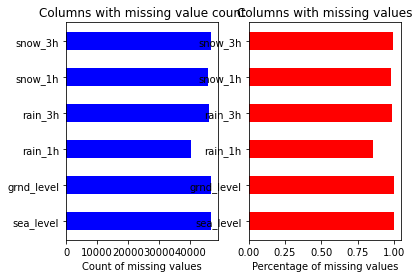

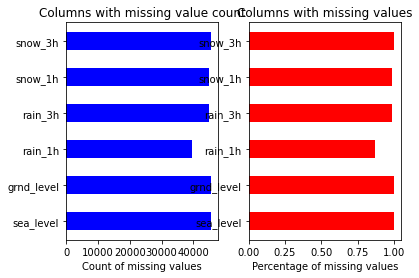

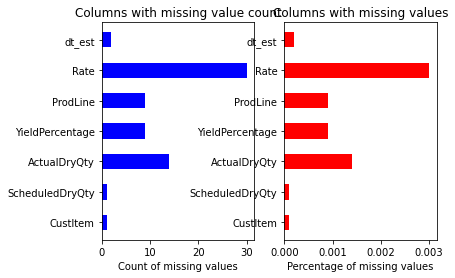

These ['CustItem', 'ScheduledDryQty', 'ActualDryQty', 'YieldPercentage', 'ProdLine', 'Rate', 'dt_est'] columns still have missing data
After dropping na, 9970 rows has decreased to 9931 rows
we will only drop too large outliers
We have 431 data points are outliers, which between 0.0 and 864.9
After drop outlier, the YieldPercentage column remain range between 71.2 and 111.0
Any data smaller than 10.04036731634183 and greater than 981.9324986390856 will be eliminate
There are 431 rows identified as extramlly outliers
We will drop too large and too small outliers
We have 327 data points are outliers, which between 819.260752688172 and 981.8181818181821
After drop outlier, the Rate column remain range between 10.06896551724138 and 818.9655172413792
We find 31 rows are duplicate. 
For each category, we have Index(['PASD339002', 'PASD372411', 'PASD376468'], dtype='object', name='BatchNumber') having [15 15  1] rows serpately
************************************************** Start row_proli

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

humidity


 20%|████████████████▊                                                                   | 1/5 [00:11<00:44, 11.02s/it]

temp


 40%|█████████████████████████████████▌                                                  | 2/5 [00:21<00:32, 10.91s/it]

temp_min


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:32<00:21, 10.93s/it]

temp_max


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:42<00:10, 10.73s/it]

pressure


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.59s/it]


These df has zero records, so we don't display them: 
2     df_04_Nutraceutical
3           df_04_Vitamin
7            df_04_Pharma
16        df_02_Fragrance
24        df_01_Fragrance
30         df_01_Cosmetic
31           df_01_Pharma
Name: DataFrame, dtype: object 


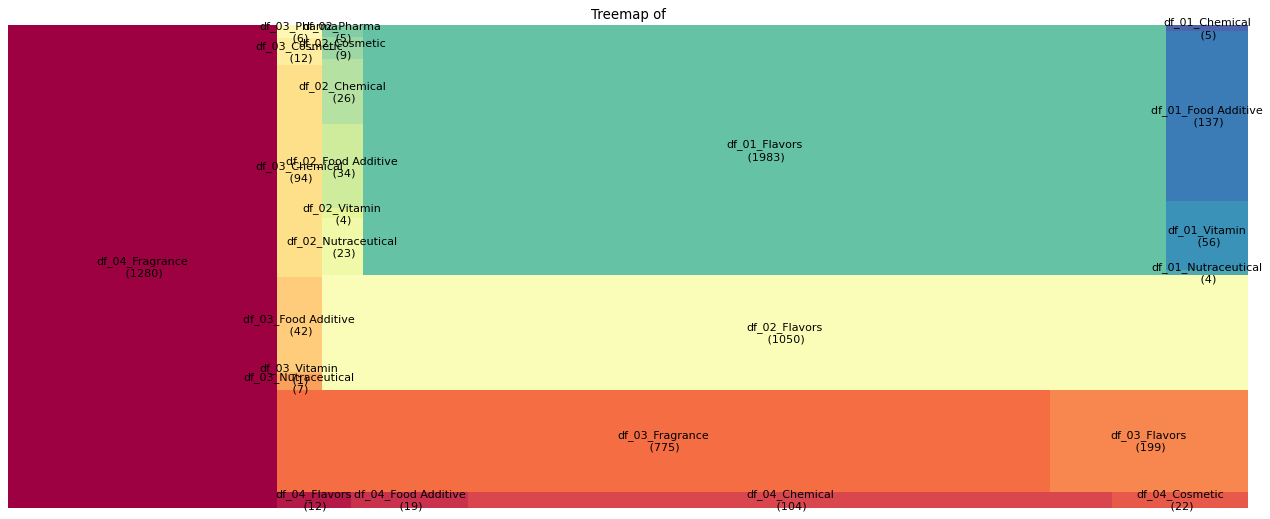

Its more easy to use records more than 100: 
0         df_04_Fragrance
5          df_04_Chemical
8         df_03_Fragrance
9           df_03_Flavors
17          df_02_Flavors
25          df_01_Flavors
28    df_01_Food Additive
Name: DataFrame, dtype: object
These df has zero records, so we don't display them: 
6          df_08_Cosmetic
13         df_07_Cosmetic
27         df_10_Cosmetic
28    df_11_Nutraceutical
29          df_11_Vitamin
32         df_11_Chemical
33           df_11_Pharma
34         df_11_Cosmetic
Name: DataFrame, dtype: object 


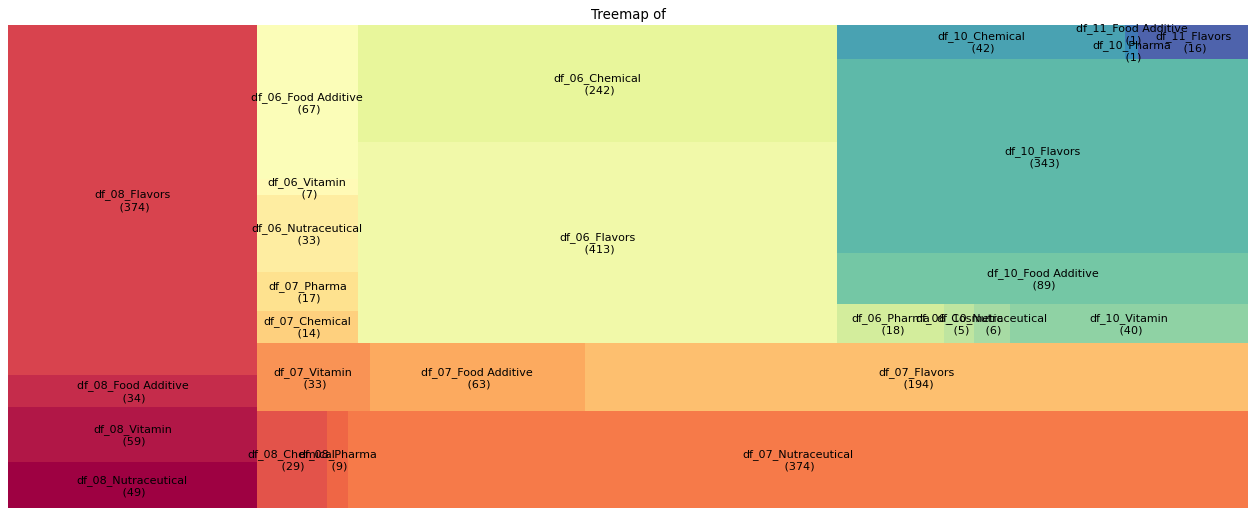

Its more easy to use records more than 100: 
3           df_08_Flavors
7     df_07_Nutraceutical
10          df_07_Flavors
17          df_06_Flavors
18         df_06_Chemical
24          df_10_Flavors
Name: DataFrame, dtype: object
Model: "nn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer_1 (InputLayer)   [(None, 26)]              0         
_________________________________________________________________
dense_layer_2 (Dense)        (None, 128)               3456      
_________________________________________________________________
dense_layer_3 (Dense)        (None, 32)                4128      
_________________________________________________________________
output_layer_4 (Dense)       (None, 5)                 165       
Total params: 7,749
Trainable params: 7,749
Non-trainable params: 0
_________________________________________________________________
Train on 224 samples, 

In [12]:
# from class_31_hyperparameters import HyperParamters
# from class_32_import_data import ImportData
# from class_34_preprocess import PreProcess
# from class_33_eda import EDA
# from class_35_merge_data import MergeData
# from class_41_feature_engineering import FeatureEngineer
# from class_42_split_compile import SplitCompile
# from class_51_nn_models import NNModels

import pandas as pd

import bar_chart_race as bcr

def main():
    """
    We use this function to call process one by one.
    """


    # ***********************import******************************
    class_import = ImportData()
    # If you don't have csv file, you should run this line first. Reading csv is more quick than excel
    # df_product_1, df_nj_weather_1, df_pa_weather_1 = class_import.import_data()
    df_product_1, df_nj_weather_1, df_pa_weather_1 = class_import.read_csv()

    # **************************EDA***************************
    class_eda = EDA()

    # *******************3.4 Preprocess**************************************
    class_pre = PreProcess()
    # convert timestmap into same format and generate detail time columns
    df_product_2, df_nj_weather_2, df_pa_weather_2 = class_pre.convert_time(df_product_1,
                                                                            df_nj_weather_1,
                                                                            df_pa_weather_1)
    # drop meanningless columns from hyperparameter and EDA result
    df_product_3, df_nj_weather_3, df_pa_weather_3 = class_pre.drop_col(df_product_2,
                                                                        df_nj_weather_2,
                                                                        df_pa_weather_2)
    # drop rows still have NaN, these just normal missing data caused by operation error
    list_col_missing_product = class_eda.missing_plot(df_product_3)
    # Drop by rows
    # we get the name of columns that has missing value from eda part
    df_product_4, df_dropped = class_pre.drop_na(df_product_3, list_col_missing_product)
    # drop outliers
    df_product_5 ,df_outlier = class_pre.drop_outlier(df_product_4)
    # There are some human issue we can modify and correct here
    df_product_6, df_nj_weather_6, df_pa_weather_6 = class_pre.clean_modify(df_product_5,
                                                                            df_nj_weather_3,
                                                                            df_pa_weather_3)

    # **********************WARNING*****************************
    # **********************WARNING*****************************
    # we should not add this code in final code, but we can temperaoly delete ['Rate']<20 for statistical result
    # Because running ['Rate'] might related to Dryer size. So we delete Dryer09 temporary
    df_product_6 = df_product_6.loc[df_product_6['Dryer']!='Dryer 09']
    df_product_6 = df_product_6.loc[df_product_6['Rate']>20]
    # **********************WARNING****************************
    # **********************WARNING****************************

    # df_product, df_nj_weather, df_pa_weather, df_dropped, df_outlier = class_pre.clean_data(df_raw_product,
    #                                                                                         df_raw_nj_weather,
    #                                                                                         df_raw_pa_weather)


    # *********************EDA*******************************
    # 1. Bar_Race_Chart
    # df_base, df_bcr= class_eda.bcr_dryer(df_product_6, df_nj_weather_6, df_pa_weather_6)
    # # we can also read it from files
    # # df_bcr = pd.read_csv('03_data/27_bcr.csv', index_col=0)
    # bcr_html = bcr.bar_chart_race(df=df_bcr.head(10), filename='30.mp4')


    #*******************3.5 MergeDate************************
    class_merge = MergeData()
    # if you need use self.df_multi in the next line, you need call function to product self.multi first
    df_multi = class_merge.row_proliferate(df_product_6)
    # identify this is only belong to
    df_nj, df_pa = class_merge.merge_location(df_product_6, df_nj_weather_6, df_pa_weather_6)

    #********************4.1 Feature Enginnering**************************
    class_fe = FeatureEngineer()
    # using feature_eng() function to produce a new df with new feature per records (not multi records but groupby)
    df_prod_nj, df_prod_pa = class_fe.feature_eng(df_product_6, df_nj, df_pa)





    #--------------------------------WARNING-----------------------------------
    #--------------------------------WARNING-----------------------------------
    #********************************INTERUPT FOR SPPED UP RUNNING TIME ************************
    # restore into 03_data
    # df_prod_nj.to_csv('03_data/34_df_prod_nj.csv', index=False)
    # df_prod_pa.to_csv('03_data/35_df_prod_pa.csv', index=False)
    # to read fast
    # df_prod_nj = pd.read_csv('03_data/34_df_prod_nj.csv')
    # df_prod_pa = pd.read_csv('03_data/35_df_prod_pa.csv')
    #***********************************************************************************************
    #--------------------------------WARNING-----------------------------------
    #--------------------------------WARNING-----------------------------------


    #*******************4.2 Split into sub dataframe*************************
    class_sc = SplitCompile()
    dict_prod_nj, df_pie_nj = class_sc.split_df(df_prod_nj)
    dict_prod_pa, df_pie_pa = class_sc.split_df(df_prod_pa)
    # get the useful df from pervious result
    df_08_Flavors = dict_prod_pa['df_08_Flavors']
    # normalize and standardlize
    class_fe = FeatureEngineer()
    X_train, X_val, X_test, y_train, y_val, y_test = class_fe.feature_scaling(df_08_Flavors)
    # transform y part into one hot
    arr_y_train = class_fe.five_calssify(y_train)
    arr_y_val = class_fe.five_calssify(y_val)
    arr_y_test = class_fe.five_calssify(y_test)

    #**********************5.1 MLP model********************************
    class_nn = NNModels()
    model_2 = class_nn.mlp_model()
    hist_2 = model_2.fit(X_train, arr_y_train, validation_data=(X_val, arr_y_val), epochs=30, batch_size=32, verbose=1)

    return (df_product_1, df_nj_weather_1, df_pa_weather_1, df_product_2, df_nj_weather_2, df_pa_weather_2,
            df_product_3, df_nj_weather_3, df_pa_weather_3, df_product_4, df_product_5, df_dropped, df_outlier,
            df_product_6, df_nj_weather_6, df_pa_weather_6,
            df_multi, df_nj, df_pa, df_prod_nj, df_prod_pa, dict_prod_nj, df_pie_nj , dict_prod_pa, df_pie_pa,
            df_08_Flavors, X_train, X_val, X_test, y_train, y_val, y_test,
            arr_y_train, arr_y_val, arr_y_test, hist_2)



if __name__=="__main__":
    """:arg
    
    """
    (df_product_1, df_nj_weather_1, df_pa_weather_1, df_product_2, df_nj_weather_2, df_pa_weather_2,
     df_product_3, df_nj_weather_3, df_pa_weather_3, df_product_4, df_product_5, df_dropped, df_outlier,
     df_product_6, df_nj_weather_6, df_pa_weather_6,
     df_multi, df_nj, df_pa, df_prod_nj, df_prod_pa, dict_prod_nj, df_pie_nj , dict_prod_pa, df_pie_pa,
     df_08_Flavors, X_train, X_val, X_test, y_train, y_val, y_test,
     arr_y_train, arr_y_val, arr_y_test, hist_2) = main()

    print("OVER")

<br>

<br>

<br>

# <a id="7.Analysis">7.Analysis</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

# <a id="7.1 Preliminary">7.1 Preliminary</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

Directly using ['Rate'] will not get Gasssian distribution

In [27]:
import seaborn as sns

D:\ProgramData\Anaconda3\envs\06_ten_GPU_22\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Rate', ylabel='Density'>

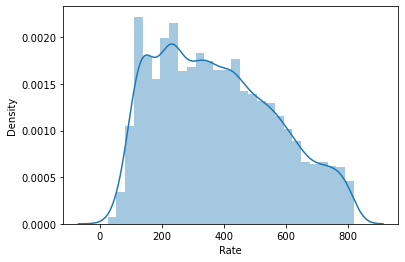

In [25]:
sns.distplot(df_product_6['Rate'])

D:\ProgramData\Anaconda3\envs\06_ten_GPU_22\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Rate', ylabel='Density'>

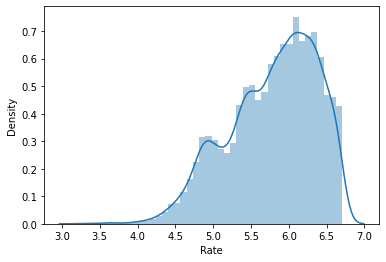

In [26]:
sns.distplot(np.log(df_product_6['Rate']))

D:\ProgramData\Anaconda3\envs\06_ten_GPU_22\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Rate'>

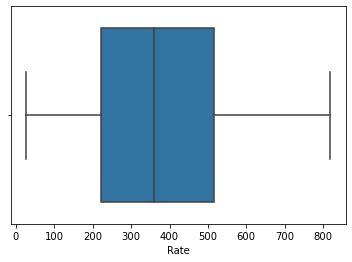

In [29]:
sns.boxplot(df_product_6['Rate'])

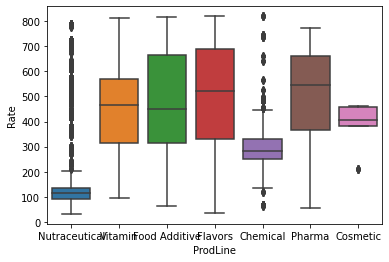

In [32]:
data_2 = pd.concat([df_pa['Rate'], df_pa['ProdLine']], axis=1)
fig = sns.boxplot(x='ProdLine', y='Rate', data=data_2)

In [1021]:
df_41 = df_pa.loc[(df_pa['ProdLine']=='Chemical') & (df_pa['Dryer'] == 'Dryer 06')]

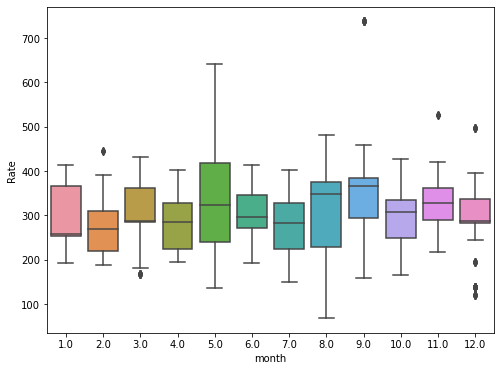

In [1023]:
fig,ax = plt.subplots(figsize=(8,6))
data_41 = pd.concat([df_41['Rate'], df_41['month']], axis=1)
fig = sns.boxplot(x='month', y='Rate', data=data_41)

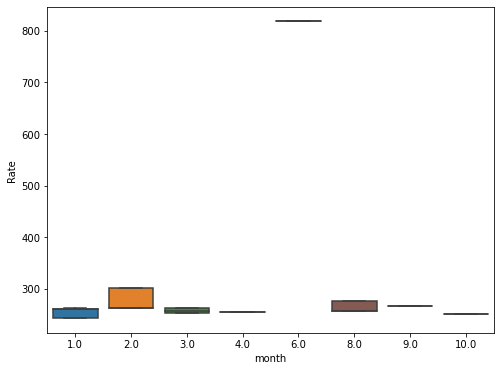

In [1024]:
df_42 = df_pa.loc[(df_pa['ProdLine']=='Chemical') & (df_pa['Dryer'] == 'Dryer 07')]
fig,ax = plt.subplots(figsize=(8,6))
data_42 = pd.concat([df_42['Rate'], df_42['month']], axis=1)
fig = sns.boxplot(x='month', y='Rate', data=data_42)

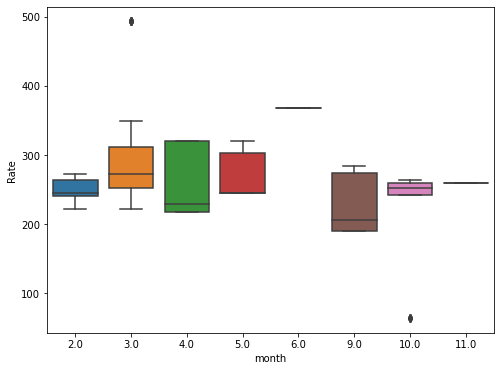

In [1025]:
df_43 = df_pa.loc[(df_pa['ProdLine']=='Chemical') & (df_pa['Dryer'] == 'Dryer 08')]
fig,ax = plt.subplots(figsize=(8,6))
data_43 = pd.concat([df_43['Rate'], df_43['month']], axis=1)
fig = sns.boxplot(x='month', y='Rate', data=data_43)

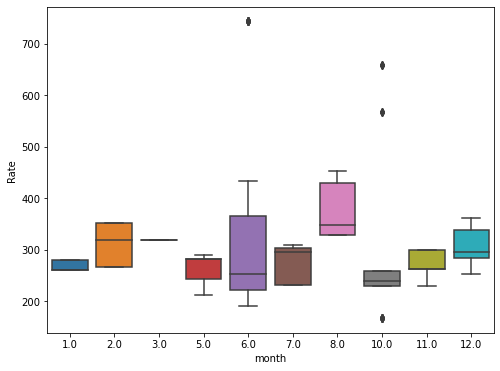

In [1026]:
df_44 = df_pa.loc[(df_pa['ProdLine']=='Chemical') & (df_pa['Dryer'] == 'Dryer 10')]
fig,ax = plt.subplots(figsize=(8,6))
data_44 = pd.concat([df_44['Rate'], df_44['month']], axis=1)
fig = sns.boxplot(x='month', y='Rate', data=data_44)

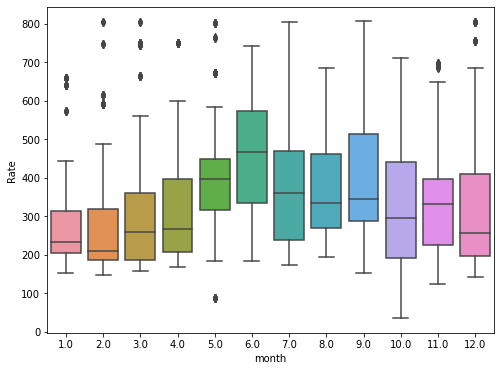

In [1027]:
df_45 = df_pa.loc[(df_pa['ProdLine']=='Flavors') & (df_pa['Dryer'] == 'Dryer 06')]
fig,ax = plt.subplots(figsize=(8,6))
data_45 = pd.concat([df_45['Rate'], df_45['month']], axis=1)
fig = sns.boxplot(x='month', y='Rate', data=data_45)

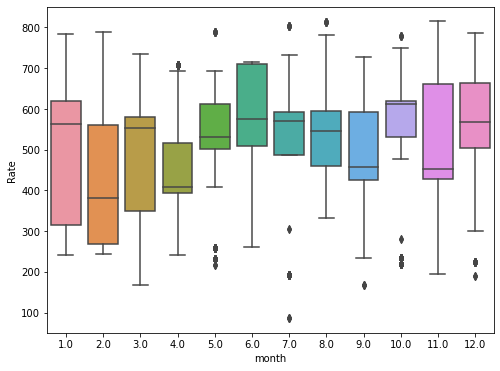

In [1028]:
df_46 = df_pa.loc[(df_pa['ProdLine']=='Flavors') & (df_pa['Dryer'] == 'Dryer 07')]
fig,ax = plt.subplots(figsize=(8,6))
data_46 = pd.concat([df_46['Rate'], df_46['month']], axis=1)
fig = sns.boxplot(x='month', y='Rate', data=data_46)

(13460, 40)


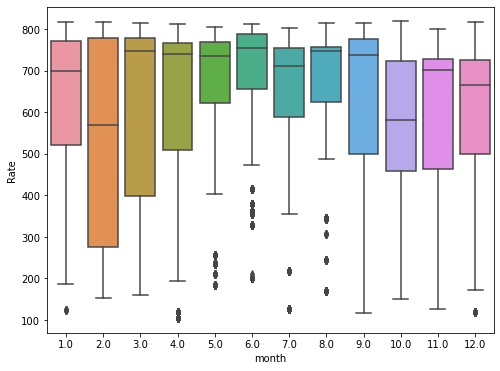

In [1030]:
df_47 = df_pa.loc[(df_pa['ProdLine']=='Flavors') & (df_pa['Dryer'] == 'Dryer 08')]
print(df_47.shape)
fig,ax = plt.subplots(figsize=(8,6))
data_47 = pd.concat([df_47['Rate'], df_47['month']], axis=1)
fig = sns.boxplot(x='month', y='Rate', data=data_47)

(9495, 40)


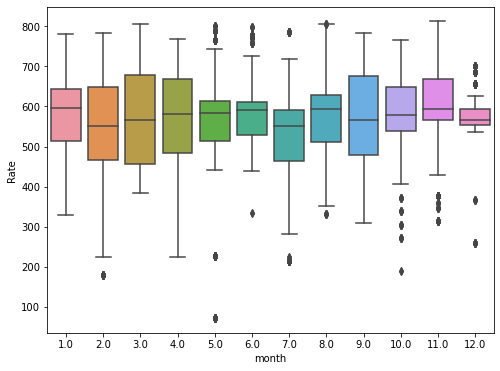

In [1031]:
df_48 = df_pa.loc[(df_pa['ProdLine']=='Flavors') & (df_pa['Dryer'] == 'Dryer 10')]
print(df_48.shape)
fig,ax = plt.subplots(figsize=(8,6))
data_48 = pd.concat([df_48['Rate'], df_48['month']], axis=1)
fig = sns.boxplot(x='month', y='Rate', data=data_48)

(2033, 40)


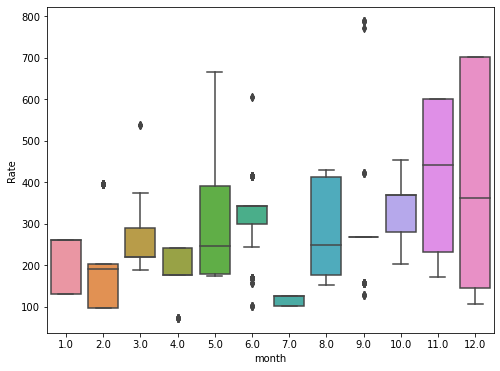

In [1032]:
df_50 = df_pa.loc[(df_pa['ProdLine']=='Food Additive') & (df_pa['Dryer'] == 'Dryer 06')]
print(df_50.shape)
fig,ax = plt.subplots(figsize=(8,6))
data_50 = pd.concat([df_50['Rate'], df_50['month']], axis=1)
fig = sns.boxplot(x='month', y='Rate', data=data_50)

(1927, 40)


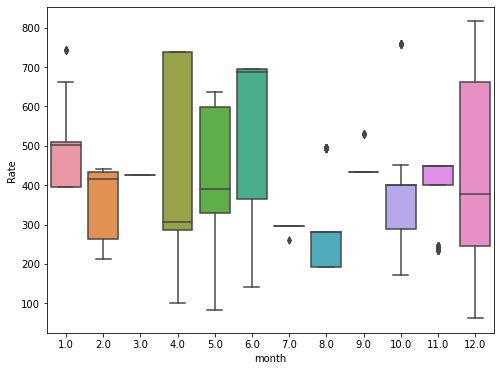

In [1033]:
df_51 = df_pa.loc[(df_pa['ProdLine']=='Food Additive') & (df_pa['Dryer'] == 'Dryer 07')]
print(df_51.shape)
fig,ax = plt.subplots(figsize=(8,6))
data_51 = pd.concat([df_51['Rate'], df_51['month']], axis=1)
fig = sns.boxplot(x='month', y='Rate', data=data_51)

(855, 40)


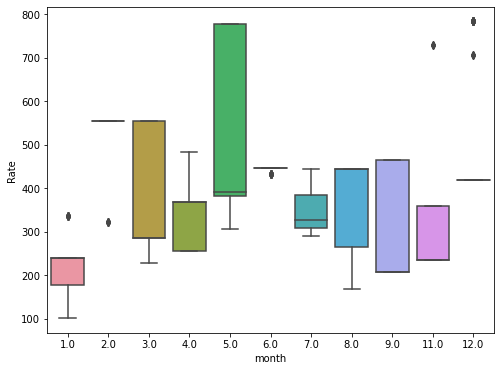

In [1034]:
df_52 = df_pa.loc[(df_pa['ProdLine']=='Food Additive') & (df_pa['Dryer'] == 'Dryer 08')]
print(df_52.shape)
fig,ax = plt.subplots(figsize=(8,6))
data_52 = pd.concat([df_52['Rate'], df_52['month']], axis=1)
fig = sns.boxplot(x='month', y='Rate', data=data_52)

(3771, 40)


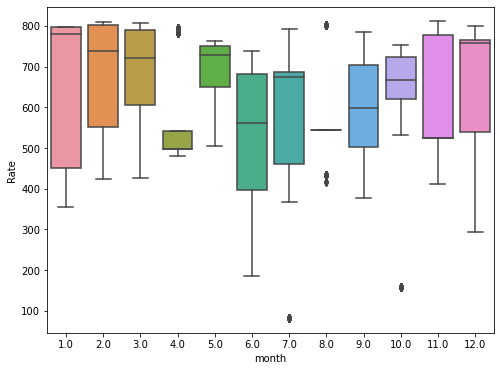

In [1035]:
df_53 = df_pa.loc[(df_pa['ProdLine']=='Food Additive') & (df_pa['Dryer'] == 'Dryer 10')]
print(df_53.shape)
fig,ax = plt.subplots(figsize=(8,6))
data_53 = pd.concat([df_53['Rate'], df_53['month']], axis=1)
fig = sns.boxplot(x='month', y='Rate', data=data_53)

(3771, 41)


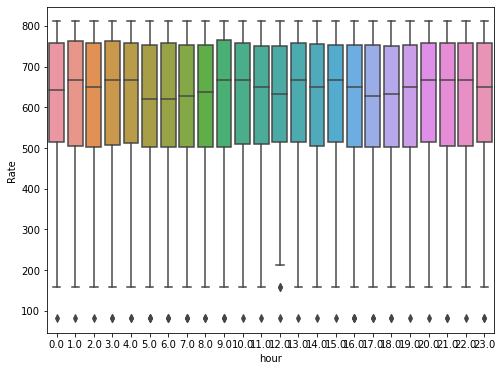

In [1052]:
df_54 = df_pa.loc[(df_pa['ProdLine']=='Food Additive') & (df_pa['Dryer'] == 'Dryer 10')]
print(df_54.shape)
fig,ax = plt.subplots(figsize=(8,6))
data_54 = pd.concat([df_54['Rate'], df_54['hour']], axis=1)
fig = sns.boxplot(x='hour', y='Rate', data=data_54)

(855, 41)


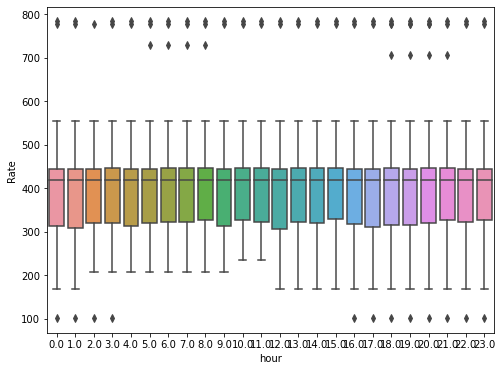

In [1053]:
df_55 = df_pa.loc[(df_pa['ProdLine']=='Food Additive') & (df_pa['Dryer'] == 'Dryer 08')]
print(df_55.shape)
fig,ax = plt.subplots(figsize=(8,6))
data_55 = pd.concat([df_55['Rate'], df_55['hour']], axis=1)
fig = sns.boxplot(x='hour', y='Rate', data=data_55)

(3771, 41)


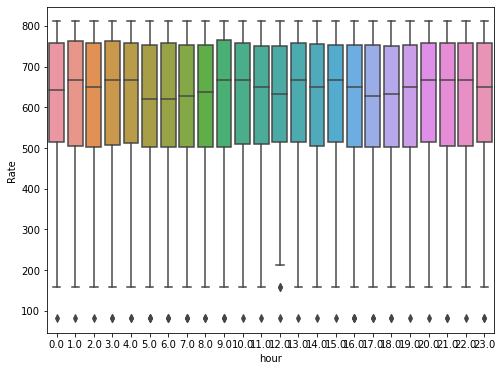

In [1054]:
df_56 = df_pa.loc[(df_pa['ProdLine']=='Food Additive') & (df_pa['Dryer'] == 'Dryer 10')]
print(df_56.shape)
fig,ax = plt.subplots(figsize=(8,6))
data_56 = pd.concat([df_56['Rate'], df_56['hour']], axis=1)
fig = sns.boxplot(x='hour', y='Rate', data=data_56)

In [41]:
print('There are {} records in NJ'.format(df_product_6.loc[df_product_6['BatchNumber'].str.contains('NJ', regex=False)].shape[0]))

There are 5909 records in NJ


In [42]:
print('If you check our multi result, they are same {} records'.format(df_nj.groupby(by=['StartDate']).count().shape[0]))

If you check our multi result, they are same 5909 records


In [43]:
print('There are {} records in PA'.format(df_product_6.loc[df_product_6['BatchNumber'].str.contains('PA', regex=False)].shape[0]))

There are 2603 records in PA


In [44]:
print('If you check our multi result, they are same {} records'.format(df_pa.groupby(by=['StartDate']).count().shape[0]))

If you check our multi result, they are same 2572 records


# <a id="8.Test Code">8.Test Code</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

1. We might need split data into two place NJ and PA, but we also can try to merge two location into one, because they are not far away
2. clean data, transform date format, join by date, Coeffience anaylsis
3. Check kaggle format
4. Check journals 
5. Check k-mean and PCA
6. Complete anormal detection function
7. build preliminary NN network
8. Do not delete YeildPercentage, we use sklearn.impute to add mean value to that outliers

In [ ]:
df_08_Flavors = dict_prod_pa['df_08_Flavors']

In [15]:
df_pie_nj

,DataFrame,RowNumber
0,df_04_Fragrance,1280
1,df_04_Flavors,12
2,df_04_Nutraceutical,0
3,df_04_Vitamin,0
4,df_04_Food Additive,19
5,df_04_Chemical,104
6,df_04_Cosmetic,22
7,df_04_Pharma,0
8,df_03_Fragrance,775
9,df_03_Flavors,199


In [17]:
df_01_Flavors = dict_prod_nj["df_01_Flavors"]

In [18]:
df_01_Flavors.shape

(1983, 41)

In [19]:
df_01 = df_01_Flavors.copy()

In [20]:
df_01['Rate']

5       303.869556
12      347.673231
21      322.687500
25      226.190476
33      264.324324
           ...    
9940    321.739130
9949    448.717949
9952    265.853659
9958    289.032258
9961    326.530612
Name: Rate, Length: 1983, dtype: float64

In [26]:
import numpy as np
import seaborn as sns

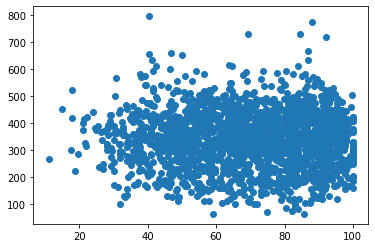

In [29]:
plt.scatter(x = df_01['humidity_mean'], y=df_01['Rate'])

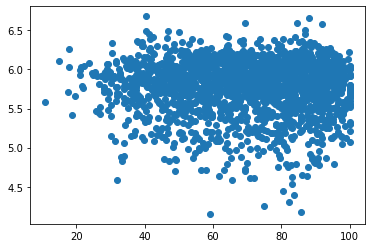

In [24]:
plt.scatter(x = df_01['humidity_mean'], y=np.log(df_01['Rate']))

D:\ProgramData\Anaconda3\envs\06_ten_GPU_22\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Rate'>

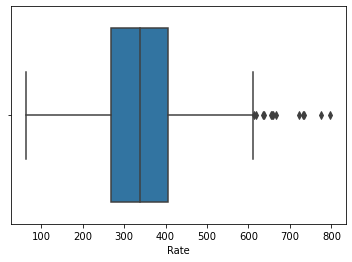

In [27]:
sns.boxplot(df_01['Rate'])

<AxesSubplot:>

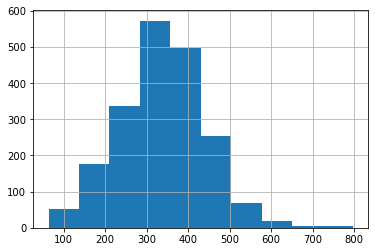

In [28]:
df_01['Rate'].hist()

In [30]:
df_01.columns

Index(['Index_ID', 'StartDate', 'BatchNumber', 'CustItem', 'Dryer',
       'ScheduledDryQty', 'ActualDryQty', 'YieldPercentage', 'DryingTime_Hrs',
       'CleanTime_Hrs', 'DownTime_Hrs', 'TotalRunTime_Hrs', 'ProdLine', 'Rate',
       'dt_est', 'hours', 'humidity_max', 'humidity_min', 'humidity_mean',
       'humidity_median', 'humidity_trend', 'temp_max', 'temp_min',
       'temp_mean', 'temp_median', 'temp_trend', 'temp_min_max',
       'temp_min_min', 'temp_min_mean', 'temp_min_median', 'temp_min_trend',
       'temp_max_max', 'temp_max_min', 'temp_max_mean', 'temp_max_median',
       'temp_max_trend', 'pressure_max', 'pressure_min', 'pressure_mean',
       'pressure_median', 'pressure_trend'],
      dtype='object')

In [45]:
class_pre = PreProcess()
df_02 = class_pre.convert_yymmdd(df_01, 'dt_est')

In [46]:
df_02.columns

Index(['Index_ID', 'StartDate', 'BatchNumber', 'CustItem', 'Dryer',
       'ScheduledDryQty', 'ActualDryQty', 'YieldPercentage', 'DryingTime_Hrs',
       'CleanTime_Hrs', 'DownTime_Hrs', 'TotalRunTime_Hrs', 'ProdLine', 'Rate',
       'dt_est', 'hours', 'humidity_max', 'humidity_min', 'humidity_mean',
       'humidity_median', 'humidity_trend', 'temp_max', 'temp_min',
       'temp_mean', 'temp_median', 'temp_trend', 'temp_min_max',
       'temp_min_min', 'temp_min_mean', 'temp_min_median', 'temp_min_trend',
       'temp_max_max', 'temp_max_min', 'temp_max_mean', 'temp_max_median',
       'temp_max_trend', 'pressure_max', 'pressure_min', 'pressure_mean',
       'pressure_median', 'pressure_trend', 'year', 'quarter', 'month', 'day',
       'hour', 'dt_date'],
      dtype='object')

In [ ]:
# we have different way to inspect our data.This list can be ProdLine
# Start from simple version, zoom into a small data set, for example, we selet 
list_vertical = ['Dryer 06', 'Dryer 07', 'Dryer 08', 'Dryer 10']

# the circtl can be ['Rate']
# the horizontal order list can be month, hour, day/night, quarter, or can be ['ProdLine']
list_horizontal = ['Chemical', 'Cosmetic', 'Flavors', 'Food Additive', 'Nutraceutical', 'Pharma', 'Vitamin']

data_ver_hor = pd.pivot_table(df_)

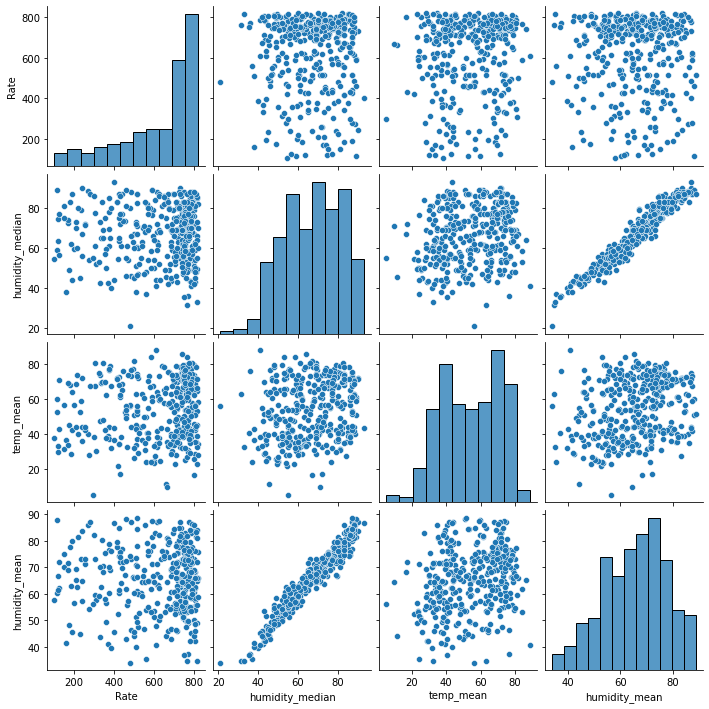

In [411]:
sns.pairplot(df_08_Flavors[['Rate', 'humidity_median','temp_mean','humidity_mean']])

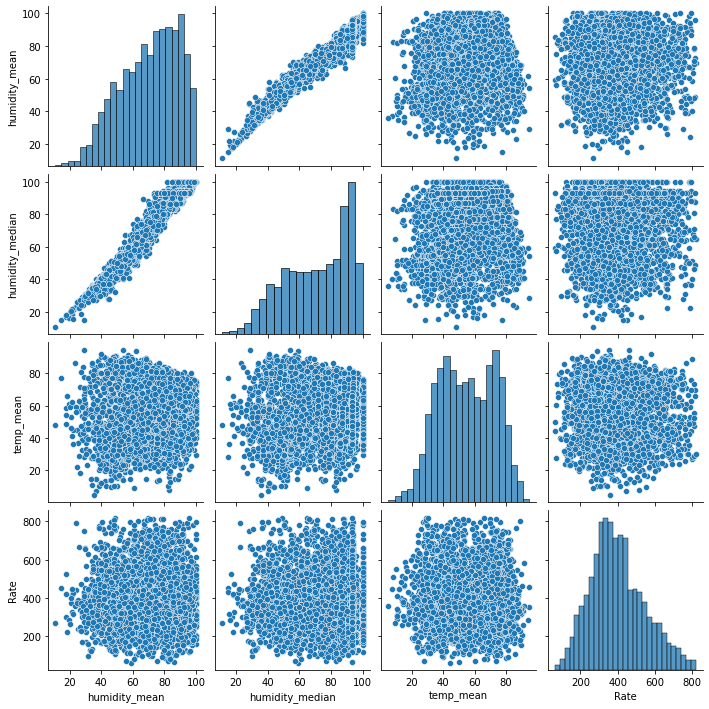

In [676]:
sns.pairplot(df_nj_flavors_2[['humidity_mean', 'humidity_median','temp_mean','Rate']])

# <a id="9.Discard Code">9.Discard Code</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [ ]:
    def clean_data(self, df_product, df_nj_weather, df_pa_weather):
        """
        ******************This function is not use anymore*******************
        ******************This function is not use anymore*******************
        ******************This function is not use anymore*******************
        All the functions in this part has beed distributed into other indivudal parts
        Delete columns we believe didn't use in the future.

        Args:
        --------
        df_product:DataFrame

        Returns:
        --------
        df_product:DataFrame
            droped missing value, add a new column['dt_est'] for merge purpose
        df_nj_weather:DataFrame
            cleaned DataFrame table

        """
        print("*" * 50, "Start clean_data()", "*" * 50)
        start_time = time()

        class_eda = EDA()


        #**************Convert all time into same timestamp format***************************
        # It should clean data first by columns then by rows, but missing data will appear when you convert time
        # From out put, we can now, 11-05 and 11-06 two records got Nan on ['dt_est'] column,
        # so we need drop them by row in the next part
        # convert weather data ['dt'] (unix time) to Eastern Stardard Time(EST)
        # pass an argument(series) to function tz_convert()
        df_nj_weather['dt_est'] = df_nj_weather['dt'].apply(self.tz_convert)
        # according to Timestamp split into year, quarter, month and day for further merge action
        df_nj_weather['year'] = df_nj_weather['dt_est'].apply(lambda x: self.tz_y_m_d(x)[0])
        df_nj_weather['quarter'] = df_nj_weather['dt_est'].apply(lambda x: self.tz_y_m_d(x)[1])
        df_nj_weather['month'] = df_nj_weather['dt_est'].apply(lambda x: self.tz_y_m_d(x)[2])
        df_nj_weather['day'] = df_nj_weather['dt_est'].apply(lambda x: self.tz_y_m_d(x)[3])
        # another way to use apply()
        # df_nj_weather['dt_est'] = df_nj_weather['dt'].apply(lambda x: pd.TimeStamp(x, unit='s', tz='America/New_York'))
        df_pa_weather['dt_est'] = df_pa_weather['dt'].apply(self.tz_convert)
        # according to Timestamp split into year, quarter, month and day for further merge action
        df_pa_weather['year'] = df_pa_weather['dt_est'].apply(lambda x: self.tz_y_m_d(x)[0])
        df_pa_weather['quarter'] = df_pa_weather['dt_est'].apply(lambda x: self.tz_y_m_d(x)[1])
        df_pa_weather['month'] = df_pa_weather['dt_est'].apply(lambda x: self.tz_y_m_d(x)[2])
        df_pa_weather['day'] = df_pa_weather['dt_est'].apply(lambda x: self.tz_y_m_d(x)[3])
        # for merge purpose, make sure two column have same name
        df_product['dt_est'] = df_product['StartDate'].apply(self.round_to_hour)
        #***********************End***************************************************


        #***************Drop non-realted columns**********************
        # *************Drop by columns**************
        # ['Bulk Density'] have 50% missing data
        df_product = df_product.drop(self.PRODUCT_DROP, axis=1)
        print("In Production sheet, these columns have been dropped {}".format(self.PRODUCT_DROP))
        # Drop un-related colunms from weather data
        df_nj_weather = df_nj_weather.drop(self.WEATHER_DROP, axis = 1)
        # some weather data might also need clearn
        list_missing_nj = class_eda.missing_plot(df_nj_weather)
        df_nj_weather = df_nj_weather.drop(list_missing_nj, axis = 1)
        list_missing_pa = class_eda.missing_plot(df_pa_weather)
        df_pa_weather = df_pa_weather.drop(list_missing_pa, axis = 1)
        #******************End************************************


        #***********************Drop missing data********************************
        list_col_missing_product = class_eda.missing_plot(df_product)
        #**************Drop by rows**********************
        # we get the name of columns that has missing value from eda part
        df_product,df_dropped = self.drop_na(df_product, list_col_missing_product)
        #******************End*****************


        #*****************Drop by outliers****************
        # after drop non-related columns, convert timestamp format, drop missing data by rows,
        # we need to drop outliers in some necessary columns
        # we might need automate generate outlier by some EDA() models
        str_col='YieldPercentage'
        df_product, df_outlier_1 = self.z_outlier(df_product, str_col, z_threshold = self.YEILD_THRESHOLD, abs=False)
        # ['Rate'] data have a lot of extramly large data. According to human judgement, >2000 might be delete.
        # But when we use statistical method to testify our data outliers
        # In z-score function, if we set value to 3, ['Rate']>1275 row=3 will be delete
        # if we set value to 2, ['Rate']>973 row=247 will be delete
        df_product, df_outlier_2 = self.z_outlier(df_product, 'Rate', z_threshold = self.IQR_THRESHOLD, abs=False)
        # concate outliers into one data frame
        frames = [df_outlier_1, df_outlier_2]
        df_outlier = pd.concat(frames)
        #*****************************End**********************


        #********************Adidtional modified*****************************
        # we have a few small changes based on some inputing error
        # For example ['Food Addit'] == ['Food Additive']
        df_product.loc[df_product['ProdLine'] == 'Food Addit', 'ProdLine'] = 'Food Additive'
        # PA only proedure food related (non-Fragance) kind custome material
        # we find a record in PA location index=3299, Batchnumber = PASD340354
        # It could be correct record but for now we delete this line
        ind=df_product[(df_product['ProdLine'] == 'Fragrance') & (df_product['BatchNumber'].str.contains('PA'))].index
        # we can use former index to drop, beacuse it's two long for one line code.
        df_product.drop(index=ind, inplace=True)

        # when we deal with product data, we find some dryer in the wrong location.
        # Generally, NJ has Dryer 01 -04, PA has Dryer 06-11.
        # For index=7491, BatchNumber ='NJSD362799' this records originally palced in NJ and then swithed over
        # to be run in PA. Typically, Spray-Tek protocal is cancel the NJ order and re-submit it as a PA order
        # In this records, the NJ order was not cancelled. The dyer number is accurate and the location is incorrect
        df_nj_1 = df_product[df_product['BatchNumber'].str.contains('NJ')]
        # then we find the index of these error recording columns
        idx_1 = df_nj_1.loc[(df_nj_1['Dryer'] == 'Dryer 06') | (df_nj_1['Dryer'] == 'Dryer 09')].index
        # idx_1 = df_nj_1.loc[df_nj_1['Dryer'].isin(['Dryer 06','Dryer 09'])].index
        # The best way to replace/assign value is use .loc[] to locate and then assign new value 'PA000'
        df_product.loc[idx_1, 'BatchNumber'] = 'PA000'
        # vice-versa, we find Dryer01 in PA, it should be in NJ
        # there index=(2761, 3245), BatchNumber=('PASD337379', 'PASD337014')
        df_pa_1 = df_product[df_product['BatchNumber'].str.contains('PA')]
        idx_2 = df_pa_1.loc[(df_pa_1['Dryer'] == 'Dryer 01')].index
        df_product.loc[idx_2, 'BatchNumber'] = 'NJ000'
        # anthoer way, If you want to assign multi-values to a pd.Series, the other head also should be pd.Serise
        # df_product.loc[idx_2, 'BatchNumber'] = df_product.loc[idx_2, 'BatchNumber'].map(lambda x: 'NJ111').values

        #*************************End**********************************************


        cost_time = round((time() - start_time), 4)
        print("*" * 40, "End clean_data() with {} second".format(cost_time), "*" * 40, end='\n\n')

        return df_product, df_nj_weather, df_pa_weather, df_dropped, df_outlier
